In [ ]:
https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

In [ ]:
https://www.gov.ie/en/news/7e0924-latest-updates-on-covid-19-coronavirus/

In [6]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import datetime
import pandas as pd
import numpy as np
import time
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

# import convoys
# import convoys.plotting
# import convoys.regression
# import convoys.single
# import convoys.utils

pd.set_option('display.max_columns', 273)
pd.set_option('display.max_rows', 273)

eu = pd.read_excel('COVID-19-geographic-disbtribution-worldwide-2020-05-02.xlsx')
#eu = pd.read_excel('COVID-19-geographic-disbtribution-worldwide-2020-11-30.xlsx')

In [7]:
df = pd.read_csv('sam_data.csv')

In [8]:
df.head()

,MARKET_ID,START_DATE,END_DATE,CAMPAIGN_NAME,MSISDN,CONTROL_STAT,RESPONDED,DAYS_OF_INACTIVITY,HORIZON,SAVED_H,SAVED_30D,SAVED_60D,CLEARED_H,CLEARED_30D,CLEARED_60D
0,3,20200227,20200302,BTL_RET_IDIRO-Churners_20200227 SG,1.246837e+10,0.0,0.0,0.0,30.0,1.0,1.0,0.0,1.0,1.0,0.0
1,1,20200325,20200330,BTL_RET_IDIRO-ChurnHVData_20200325_DT,1.758712e+10,0.0,0.0,4.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,20200325,20200330,BTL_RET_IDIRO-ChurnHVData_20200325_DT,1.758724e+10,0.0,1.0,0.0,30.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1,20200212,20200218,BTL_RET_IDIRO-ChurnLVData_20200212_DT,1.758726e+10,0.0,0.0,2.0,28.0,1.0,1.0,1.0,1.0,1.0,1.0
4,7,20200311,20200316,BTL_RET_IDIRO-LVChurn_20200311_DT,1.784434e+10,0.0,0.0,5.0,25.0,1.0,1.0,0.0,1.0,1.0,0.0


In [9]:
eu.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,2020-05-02,2,5,2020,164,4,Afghanistan,AF,AFG,37172386.0,Asia
1,2020-05-01,1,5,2020,222,4,Afghanistan,AF,AFG,37172386.0,Asia
2,2020-04-30,30,4,2020,122,0,Afghanistan,AF,AFG,37172386.0,Asia
3,2020-04-29,29,4,2020,124,3,Afghanistan,AF,AFG,37172386.0,Asia
4,2020-04-28,28,4,2020,172,0,Afghanistan,AF,AFG,37172386.0,Asia


In [10]:
eu = pd.read_excel('COVID-19-geographic-disbtribution-worldwide-2020-11-30.xlsx')

In [11]:
eu.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,2020-11-30,30,11,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,6.416633
1,2020-11-29,29,11,2020,228,11,Afghanistan,AF,AFG,38041757.0,Asia,6.845110
2,2020-11-28,28,11,2020,214,15,Afghanistan,AF,AFG,38041757.0,Asia,6.784650
3,2020-11-27,27,11,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,6.395604
4,2020-11-26,26,11,2020,200,12,Afghanistan,AF,AFG,38041757.0,Asia,7.341932


In [12]:
eu = eu.drop(['geoId'], axis=1)

eu.rename(columns={'dateRep': 'DATE'}, inplace=True)
eu.rename(columns={'countriesAndTerritories': 'COUNTRY'}, inplace=True)
eu.rename(columns={'cases': 'CASES'}, inplace=True)
eu.rename(columns={'deaths': 'DEATHS'}, inplace=True)
eu.rename(columns={'popData2019': 'POPULATION'}, inplace=True)

## COLUMN of the Cumulative Cases

def custcum(x):
    x = x.sort_values(by='DATE')
    total = 0
    for i, v in x.iterrows():
        total += v.CASES
        country = v.COUNTRY
        x.loc[i, 'CUM_CASES'] = total
        if country != v.COUNTRY:
            total = 0
    return x

eu = eu.groupby('COUNTRY').apply(custcum)
eu = eu.drop(['COUNTRY'], axis=1)
eu = eu.reset_index()
eu = eu.drop(['level_1'], axis=1)

## COLUMN of the Cumulative Deaths

def custcum(x):
    x = x.sort_values(by='DATE')
    total = 0
    for i, v in x.iterrows():
        total += v.DEATHS
        country = v.COUNTRY
        x.loc[i, 'CUM_DEATHS'] = total
        if country != v.COUNTRY:
            total = 0
    return x

eu = eu.groupby('COUNTRY').apply(custcum)
eu = eu.drop(['COUNTRY'], axis=1)
eu = eu.reset_index()
eu = eu.drop(['level_1'], axis=1)

eu['INFECTED_CUM_FRXN'] = (eu.CUM_CASES / eu.POPULATION)

### getting the at least 5 infections date per country ######
country_list = eu.groupby('COUNTRY').min().index.values
first_infxn_list = []
for country in eu.groupby('COUNTRY').min().index.values:
    first_infxn_list.append(eu[(eu.COUNTRY == country) & (eu.CASES > 5)].DATE.min())

dataset = pd.DataFrame({'AT_LEAST_5_DAILY_CASES_DATE': first_infxn_list, 'COUNTRY': country_list})

eu = pd.merge(eu, dataset, right_on='COUNTRY', left_on='COUNTRY', how='inner')
eu.rename(columns={'DATE_y': 'FIRST_INFEXN_DATE'}, inplace=True)
eu.rename(columns={'DATE_x': 'DATE'}, inplace=True)

eu['DAYS_SINCE_5_INFXNS'] = (eu.DATE - eu.AT_LEAST_5_DAILY_CASES_DATE).dt.days


### getting the date per country where > 1 in 1e6 ? are infected ######
country_list = eu.groupby('COUNTRY').min().index.values
first_infxn_list = []
for country in eu.groupby('COUNTRY').min().index.values:
    first_infxn_list.append(eu[(eu.COUNTRY == country) & (eu.INFECTED_CUM_FRXN > 1e-6)].DATE.min())

dataset = pd.DataFrame({'AT_LEAST_1_in_1e6_infected': first_infxn_list, 'COUNTRY': country_list})

eu = pd.merge(eu, dataset, right_on='COUNTRY', left_on='COUNTRY', how='inner')
eu.rename(columns={'DATE_y': 'START_DATE'}, inplace=True)
eu.rename(columns={'DATE_x': 'DATE'}, inplace=True)

eu['DAYS_SINCE_INFXN_START'] = (eu.DATE - eu.AT_LEAST_1_in_1e6_infected).dt.days

In [13]:
eu.to_csv('COVID_DATA_11_30_2020_IVAN.csv')

In [14]:
eu.head()

,COUNTRY,DATE,day,month,year,CASES,DEATHS,countryterritoryCode,POPULATION,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,CUM_CASES,CUM_DEATHS,INFECTED_CUM_FRXN,AT_LEAST_5_DAILY_CASES_DATE,DAYS_SINCE_5_INFXNS,AT_LEAST_1_in_1e6_infected,DAYS_SINCE_INFXN_START
0,Afghanistan,2019-12-31,31,12,2019,0,0,AFG,38041757.0,Asia,NaN,0.0,0.0,0.0,2020-03-16,-76.0,2020-03-24,-84.0
1,Afghanistan,2020-01-01,1,1,2020,0,0,AFG,38041757.0,Asia,NaN,0.0,0.0,0.0,2020-03-16,-75.0,2020-03-24,-83.0
2,Afghanistan,2020-01-02,2,1,2020,0,0,AFG,38041757.0,Asia,NaN,0.0,0.0,0.0,2020-03-16,-74.0,2020-03-24,-82.0
3,Afghanistan,2020-01-03,3,1,2020,0,0,AFG,38041757.0,Asia,NaN,0.0,0.0,0.0,2020-03-16,-73.0,2020-03-24,-81.0
4,Afghanistan,2020-01-04,4,1,2020,0,0,AFG,38041757.0,Asia,NaN,0.0,0.0,0.0,2020-03-16,-72.0,2020-03-24,-80.0


In [15]:
eu.groupby('COUNTRY').count()

,DATE,day,month,year,CASES,DEATHS,countryterritoryCode,POPULATION,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,CUM_CASES,CUM_DEATHS,INFECTED_CUM_FRXN,AT_LEAST_5_DAILY_CASES_DATE,DAYS_SINCE_5_INFXNS,AT_LEAST_1_in_1e6_infected,DAYS_SINCE_INFXN_START
COUNTRY,,,,,,,,,,,,,,,,,
Afghanistan,326,326,326,326,326,326,326,326,326,313,326,326,326,326,326,326,326
Albania,267,267,267,267,267,267,267,267,267,254,267,267,267,267,267,267,267
Algeria,330,330,330,330,330,330,330,330,330,317,330,330,330,330,330,330,330
Andorra,262,262,262,262,262,262,262,262,262,249,262,262,262,262,262,262,262
Angola,253,253,253,253,253,253,253,253,253,240,253,253,253,253,253,253,253
Anguilla,249,249,249,249,249,249,249,249,249,236,249,249,249,0,0,249,249
Antigua_and_Barbuda,256,256,256,256,256,256,256,256,256,243,256,256,256,256,256,256,256
Argentina,269,269,269,269,269,269,269,269,269,256,269,269,269,269,269,269,269
Armenia,327,327,327,327,327,327,327,327,327,314,327,327,327,327,327,327,327


In [21]:
print (len(eu.groupby('COUNTRY').count().index.values), ' Count of Countries')
print('')

country1 = 'United_States_of_America'#'China'
country2 = 'Italy'
country3 = 'South_Korea'
country4 = 'Japan'
country5 = 'Ireland'
country6 = 'Spain'
country7 = 'France'
country8 = 'Taiwan'
country9 = 'Sweden'
country10 = 'Singapore' #'United States of America'

frxn1  = np.divide(np.cumsum(eu[eu.COUNTRY == country1].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country1].POPULATION.values[0])
frxn2  = np.divide(np.cumsum(eu[eu.COUNTRY == country2].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country2].POPULATION.values[0])
frxn3  = np.divide(np.cumsum(eu[eu.COUNTRY == country3].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country3].POPULATION.values[0])
frxn4  = np.divide(np.cumsum(eu[eu.COUNTRY == country4].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country4].POPULATION.values[0])
frxn5  = np.divide(np.cumsum(eu[eu.COUNTRY == country5].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country5].POPULATION.values[0])
frxn6  = np.divide(np.cumsum(eu[eu.COUNTRY == country6].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country6].POPULATION.values[0])
frxn7  = np.divide(np.cumsum(eu[eu.COUNTRY == country7].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country7].POPULATION.values[0])
frxn8  = np.divide(np.cumsum(eu[eu.COUNTRY == country8].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country8].POPULATION.values[0])
frxn9  = np.divide(np.cumsum(eu[eu.COUNTRY == country9].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country9].POPULATION.values[0])
frxn10 = np.divide(np.cumsum(eu[eu.COUNTRY == country10].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country10].POPULATION.values[0])

abs1  = np.cumsum(eu[eu.COUNTRY == country1].sort_values(by = 'DATE').CASES).values
abs2  = np.cumsum(eu[eu.COUNTRY == country2].sort_values(by = 'DATE').CASES).values
abs3  = np.cumsum(eu[eu.COUNTRY == country3].sort_values(by = 'DATE').CASES).values
abs4  = np.cumsum(eu[eu.COUNTRY == country4].sort_values(by = 'DATE').CASES).values
abs5  = np.cumsum(eu[eu.COUNTRY == country5].sort_values(by = 'DATE').CASES).values
abs6  = np.cumsum(eu[eu.COUNTRY == country6].sort_values(by = 'DATE').CASES).values
abs7  = np.cumsum(eu[eu.COUNTRY == country7].sort_values(by = 'DATE').CASES).values
abs8  = np.cumsum(eu[eu.COUNTRY == country8].sort_values(by = 'DATE').CASES).values
abs9  = np.cumsum(eu[eu.COUNTRY == country9].sort_values(by = 'DATE').CASES).values
abs10 = np.cumsum(eu[eu.COUNTRY == country10].sort_values(by = 'DATE').CASES).values

x1  = eu[eu.COUNTRY == country1].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x2  = eu[eu.COUNTRY == country2].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x3  = eu[eu.COUNTRY == country3].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x4  = eu[eu.COUNTRY == country4].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x5  = eu[eu.COUNTRY == country5].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x6  = eu[eu.COUNTRY == country6].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x7  = eu[eu.COUNTRY == country7].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x8  = eu[eu.COUNTRY == country8].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x9  = eu[eu.COUNTRY == country9].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x10 = eu[eu.COUNTRY == country10].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values

214  Count of Countries



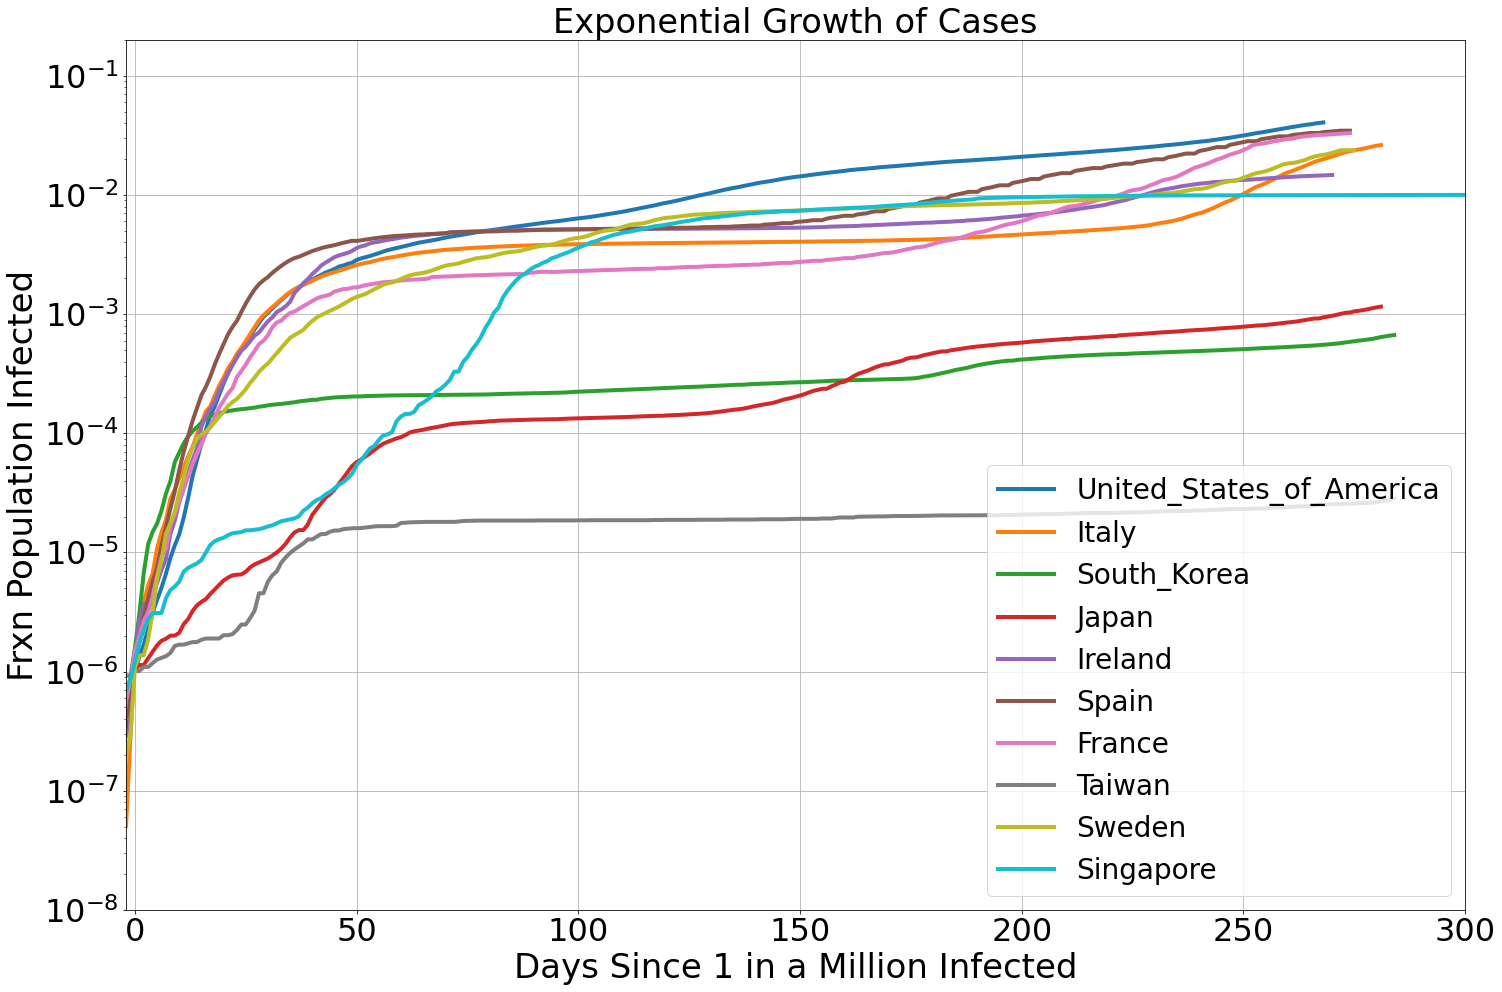

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 16, forward=True)

ax.plot(x1,  frxn1,   '-', label = country1, linewidth=4)
ax.plot(x2,  frxn2,   '-', label = country2, linewidth=4)
ax.plot(x3,  frxn3,   '-', label = country3, linewidth=4)
ax.plot(x4,  frxn4,   '-', label = country4, linewidth=4)
ax.plot(x5,  frxn5,   '-', label = country5, linewidth=4)
ax.plot(x6,  frxn6,   '-', label = country6, linewidth=4)
ax.plot(x7,  frxn7,   '-', label = country7, linewidth=4)
ax.plot(x8,  frxn8,   '-', label = country8, linewidth=4)
ax.plot(x9,  frxn9,   '-', label = country9, linewidth=4)
ax.plot(x10, frxn10,   '-', label = country10, linewidth=4)


plt.rc('font', size=28)
#plt.xlabel('DATE', fontsize=20)

plt.ylabel("Frxn Population Infected", fontsize=34)
plt.xlabel("Days Since 1 in a Million Infected", fontsize=34)
#_ = plt.plot([0.01, 1], [0.01, 1])

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.title(country, fontsize = 28)

# ml = MultipleLocator(.1)
# ax.yaxis.set_minor_locator(ml)
# ax.yaxis.grid(which="minor", color='k', linestyle='-', linewidth=0.7)

plt.xlim(-2 ,300)
plt.xticks(rotation=0)
plt.ylim(1e-8,0.2)
plt.yscale('log')
#plt.xscale('log')
plt.title('Exponential Growth of Cases')

plt.legend()

plt.grid(True)
plt.show()

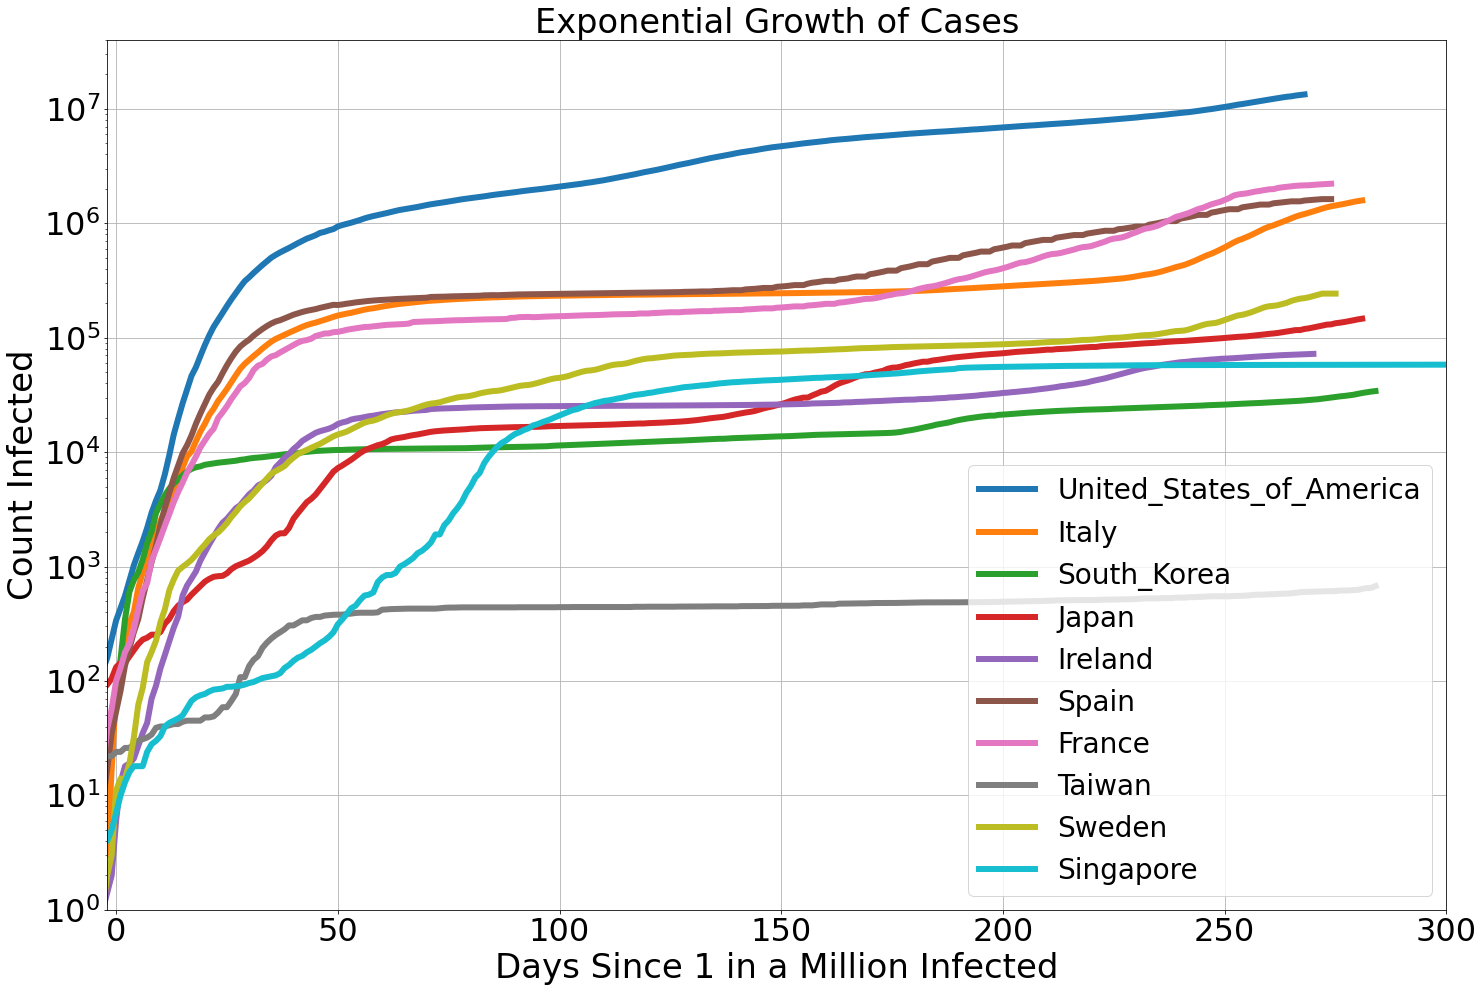

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 16, forward=True)

ax.plot(x1,  abs1,   '-', label = country1, linewidth=6)
ax.plot(x2,  abs2,   '-', label = country2, linewidth=6)
ax.plot(x3,  abs3,   '-', label = country3, linewidth=6)
ax.plot(x4,  abs4,   '-', label = country4, linewidth=6)
ax.plot(x5,  abs5,   '-', label = country5, linewidth=6)
ax.plot(x6,  abs6,   '-', label = country6, linewidth=6)
ax.plot(x7,  abs7,   '-', label = country7, linewidth=6)
ax.plot(x8,  abs8,   '-', label = country8, linewidth=6)
ax.plot(x9,  abs9,   '-', label = country9, linewidth=6)
ax.plot(x10, abs10,   '-', label = country10, linewidth=6)


plt.rc('font', size=28)
#plt.xlabel('DATE', fontsize=20)
plt.ylabel("Count Infected", fontsize=34)
plt.xlabel("Days Since 1 in a Million Infected", fontsize=34)
#_ = plt.plot([0.01, 1], [0.01, 1])

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.title(country, fontsize = 34)

plt.xlim(-2 ,300)
plt.xticks(rotation=0)

plt.ylim(1,4e7)
plt.yscale('log')
#plt.xscale('log')
plt.title('Exponential Growth of Cases')

plt.legend()

plt.grid(True)
plt.show()

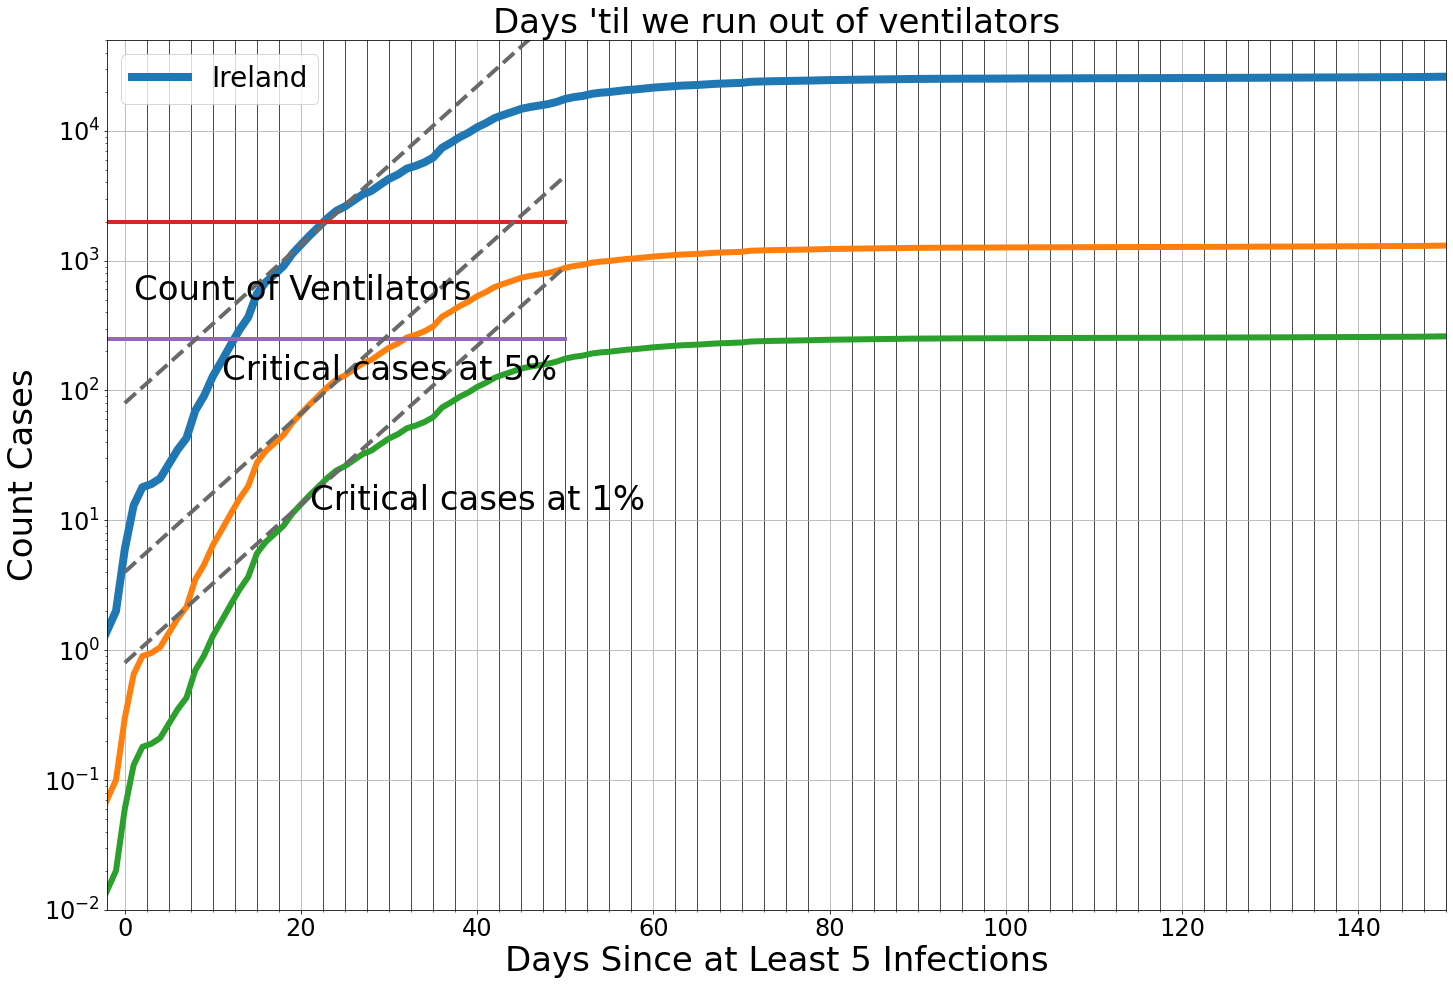

In [27]:
Ven = lambda x: 1229 if x< 24 else(1529 if x<54 else 2129)

ven_list = []
for x in range(90):
    ven_list.append(Ven(x))

country1 = 'United_States_of_America'#'China'
country2 = 'Italy'
country3 = 'South_Korea'
country4 = 'Japan'
country5 = 'Ireland'
country6 = 'Spain'
country7 = 'France'
country8 = 'Iran'
country9 = 'United_Kingdom'
country10 = 'Netherlands' #'United States of America'


fig, ax = plt.subplots()
fig.set_size_inches(24, 16, forward=True)

ax.plot(x5, abs5,   '-', label = country5, linewidth=8)
ax.plot(x5, np.divide(abs5,20),   '-', linewidth=6)
ax.plot(x5, np.divide(abs5,100),   '-', linewidth=6)
#ax.plot(x5, ven_list,   '-', label = country5, linewidth=8)


plt.rc('font', size=28)
#plt.xlabel('DATE', fontsize=20)
plt.ylabel("Count Cases", fontsize=34)
plt.xlabel("Days Since at Least 5 Infections", fontsize=34)

_ = plt.plot([-10, 50], [2000, 2000], linewidth=4)  # number of ventilators
_ = plt.plot([-10, 50], [250, 250], linewidth=4)  # number of ICU beds

x2 = 80
y2 = 90000

_ = plt.plot([0, 50], [x2, y2], '--', linewidth=4, color = 'dimgrey')  # number of cases
_ = plt.plot([0, 50], [x2/100, y2/100], '--', linewidth=4, color = 'dimgrey')  # number of critical cases @ 1% critical rate
_ = plt.plot([0, 50], [x2/20, y2/20], '--', linewidth=4, color = 'dimgrey')  # number of critical cases @ 5% critical rate


plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.title(country, fontsize = 28)

ml = MultipleLocator(2.5)
ax.xaxis.set_minor_locator(ml)
ax.xaxis.grid(which="minor", color='k', linestyle='-', linewidth=0.7)

# ml = MultipleLocator(0.1)
# ax.yaxis.set_minor_locator(ml)
# ax.yaxis.grid(which="minor", color='k', linestyle='-', linewidth=0.7)

plt.xlim(-2 ,150)
plt.xticks(rotation=0)
plt.ylim(1e-2,50000)
plt.yscale('log')
#plt.xscale('log')
plt.title("Days 'til we run out of ventilators", fontsize=34)

plt.text(21, 12, 'Critical cases at 1%', fontsize=34)
plt.text(11, 120, 'Critical cases at 5%', fontsize=34)
plt.text(1, 500, 'Count of Ventilators', fontsize=34)

plt.legend()

plt.grid(True)
plt.show()


In [28]:
x2

80

In [29]:
x6

array([-60., -59., -58., -57., -56., -55., -54., -53., -52., -51., -50.,
       -49., -48., -47., -46., -45., -44., -43., -42., -41., -40., -39.,
       -38., -37., -36., -35., -34., -33., -32., -31., -30., -29., -28.,
       -27., -26., -25., -24., -23., -22., -21., -20., -19., -18., -17.,
       -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,
        -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,
         6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,
        17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,
        28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,
        39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,
        50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
        72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,
        83.,  84.,  85.,  86.,  87.,  88.,  89.,  9

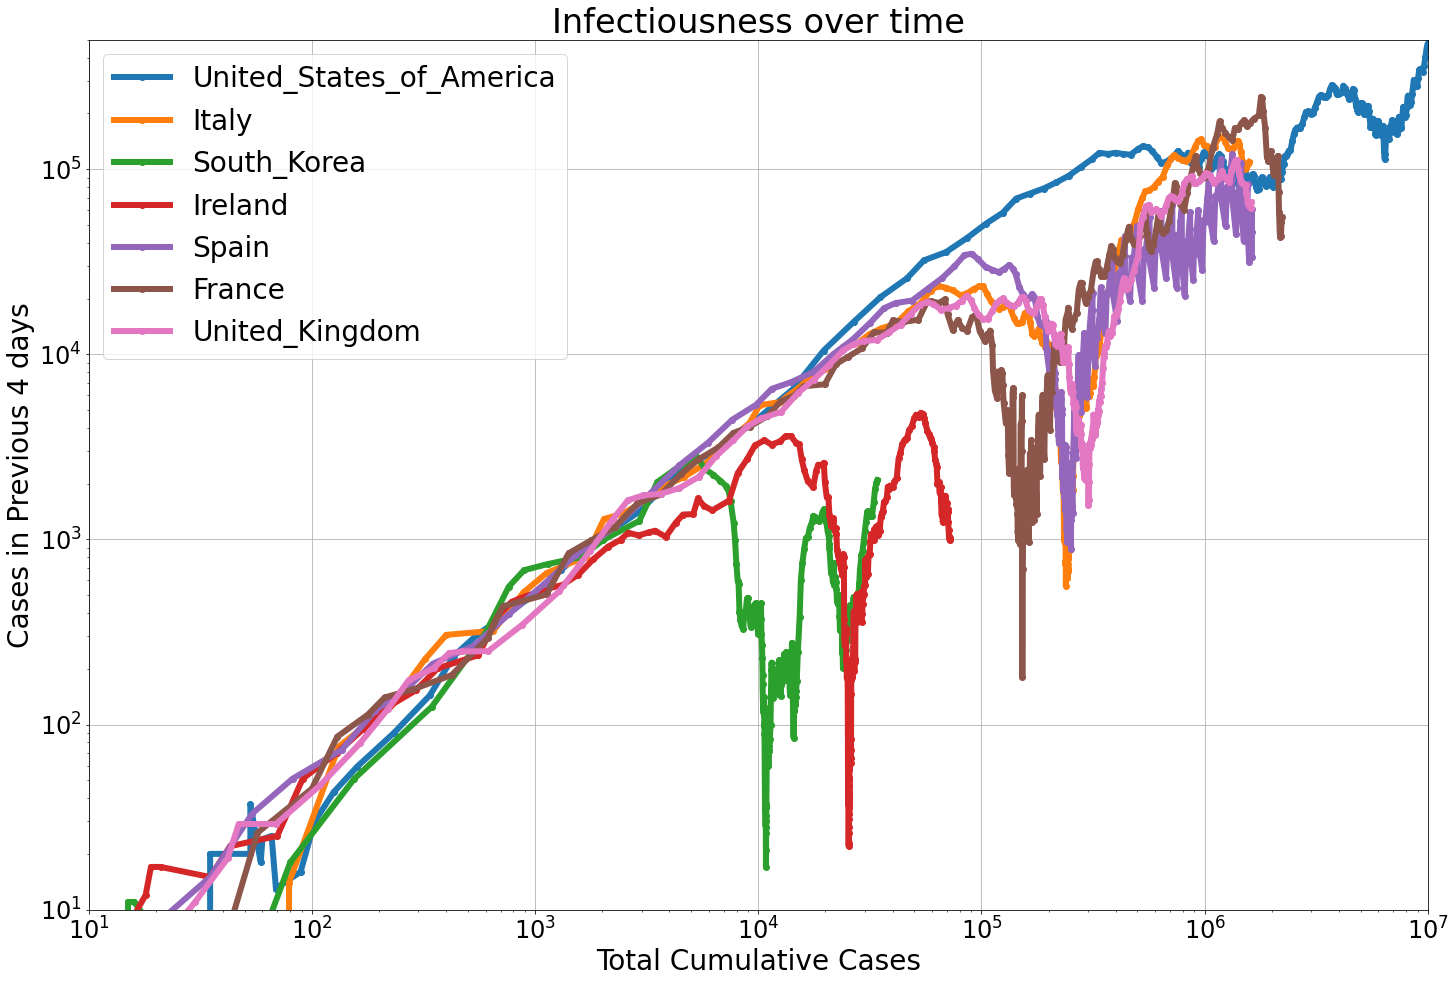

In [31]:
T = 4

country1 = 'United_States_of_America'#'China'
country2 = 'Italy'
country3 = 'South_Korea'
country4 = 'Japan'
country5 = 'Ireland'
country6 = 'Spain'
country7 = 'France'
country8 = 'Iran'
country9 = 'United_Kingdom'
country10 = 'China' #'United States of America'



x1  = eu[eu.COUNTRY == country1].sort_values(by = 'DATE').CUM_CASES.values
x2  = eu[eu.COUNTRY == country2].sort_values(by = 'DATE').CUM_CASES.values
x3  = eu[eu.COUNTRY == country3].sort_values(by = 'DATE').CUM_CASES.values
x4  = eu[eu.COUNTRY == country4].sort_values(by = 'DATE').CUM_CASES.values
x5  = eu[eu.COUNTRY == country5].sort_values(by = 'DATE').CUM_CASES.values
x6  = eu[eu.COUNTRY == country6].sort_values(by = 'DATE').CUM_CASES.values
x7  = eu[eu.COUNTRY == country7].sort_values(by = 'DATE').CUM_CASES.values
x8  = eu[eu.COUNTRY == country8].sort_values(by = 'DATE').CUM_CASES.values
x9  = eu[eu.COUNTRY == country9].sort_values(by = 'DATE').CUM_CASES.values
x10  = eu[eu.COUNTRY == country10].sort_values(by = 'DATE').CUM_CASES.values

set1 = (eu[eu.COUNTRY == country1].sort_values(by = 'DATE').CASES).values
set2 = (eu[eu.COUNTRY == country2].sort_values(by = 'DATE').CASES).values
set3 = (eu[eu.COUNTRY == country3].sort_values(by = 'DATE').CASES).values
set4 = (eu[eu.COUNTRY == country4].sort_values(by = 'DATE').CASES).values
set5 = (eu[eu.COUNTRY == country5].sort_values(by = 'DATE').CASES).values
set6 = (eu[eu.COUNTRY == country6].sort_values(by = 'DATE').CASES).values
set7 = (eu[eu.COUNTRY == country7].sort_values(by = 'DATE').CASES).values
set8 = (eu[eu.COUNTRY == country8].sort_values(by = 'DATE').CASES).values
set9 = (eu[eu.COUNTRY == country9].sort_values(by = 'DATE').CASES).values
set10 = (eu[eu.COUNTRY == country10].sort_values(by = 'DATE').CASES).values

r_0_list_1 = []
r_0_list_2 = []
r_0_list_3 = []
r_0_list_4 = []
r_0_list_5 = []
r_0_list_6 = []
r_0_list_7 = []
r_0_list_8 = []
r_0_list_9 = []
r_0_list_10 = []

for i in range(len(set1)):
    try:
        r_0_1 = np.sum(set1[i-T:i])
    except:
        pass

    r_0_list_1.append(r_0_1)
    
for i in range(len(set2)):
    try:
        r_0_2 = np.sum(set2[i-T:i])
    except:
        pass

    r_0_list_2.append(r_0_2)
    
for i in range(len(set3)):
    try:
        r_0_3 = np.sum(set3[i-T:i])
    except:
        pass

    r_0_list_3.append(r_0_3)
    
for i in range(len(set4)):
    try:
        r_0_4 = np.sum(set4[i-T:i])
    except:
        pass

    r_0_list_4.append(r_0_4)
    
for i in range(len(set5)):
    try:
        r_0_5 = np.sum(set5[i-T:i])
    except:
        pass

    r_0_list_5.append(r_0_5)
    
for i in range(len(set6)):
    try:
        r_0_6 = np.sum(set6[i-T:i])
    except:
        pass

    r_0_list_6.append(r_0_6)
    
for i in range(len(set7)):
    try:
        r_0_7 = np.sum(set7[i-T:i])
    except:
        pass

    r_0_list_7.append(r_0_7)
    
for i in range(len(set8)):
    try:
        r_0_8 = np.sum(set8[i-T:i])
    except:
        pass

    r_0_list_8.append(r_0_8)
    
for i in range(len(set9)):
    try:
        r_0_9 = np.sum(set9[i-T:i])
    except:
        pass

    r_0_list_9.append(r_0_9)
    
for i in range(len(set10)):
    try:
        r_0_10 = np.sum(set10[i-T:i])
    except:
        pass

    r_0_list_10.append(r_0_10)


fig, ax = plt.subplots()
fig.set_size_inches(24, 16, forward=True)


ax.plot(x1, r_0_list_1,   'o-', label = country1, linewidth=6)
ax.plot(x2, r_0_list_2,   'o-', label = country2, linewidth=6)
ax.plot(x3, r_0_list_3,   'o-', label = country3, linewidth=6)
#ax.plot(x4, r_0_list_4,   'o-', label = country4, linewidth=6)
ax.plot(x5, r_0_list_5,   'o-', label = country5, linewidth=6)
ax.plot(x6, r_0_list_6,   'o-', label = country6, linewidth=6)
ax.plot(x7, r_0_list_7,   'o-', label = country7, linewidth=6)
#ax.plot(x8, r_0_list_8,   'o-', label = country8, linewidth=6)
ax.plot(x9, r_0_list_9,   'o-', label = country9, linewidth=6)
#x.plot(x10, r_0_list_10,   'o-', label = country10, linewidth=6)


plt.rc('font', size=28)
#plt.xlabel('DATE', fontsize=20)
plt.ylabel("Cases in Previous 4 days", fontsize=28)
plt.xlabel("Total Cumulative Cases", fontsize=28)
#_ = plt.plot([0.01, 1], [0.01, 1])

plt.xticks(fontsize=24)
plt.xticks(rotation=0)

plt.yticks(fontsize=24)
plt.title(country, fontsize = 28)

plt.xlim(10,1e7)
plt.ylim(10,5e5)



plt.yscale('log')
plt.xscale('log')
plt.title('Infectiousness over time')

plt.legend()

plt.grid(True)
plt.show()

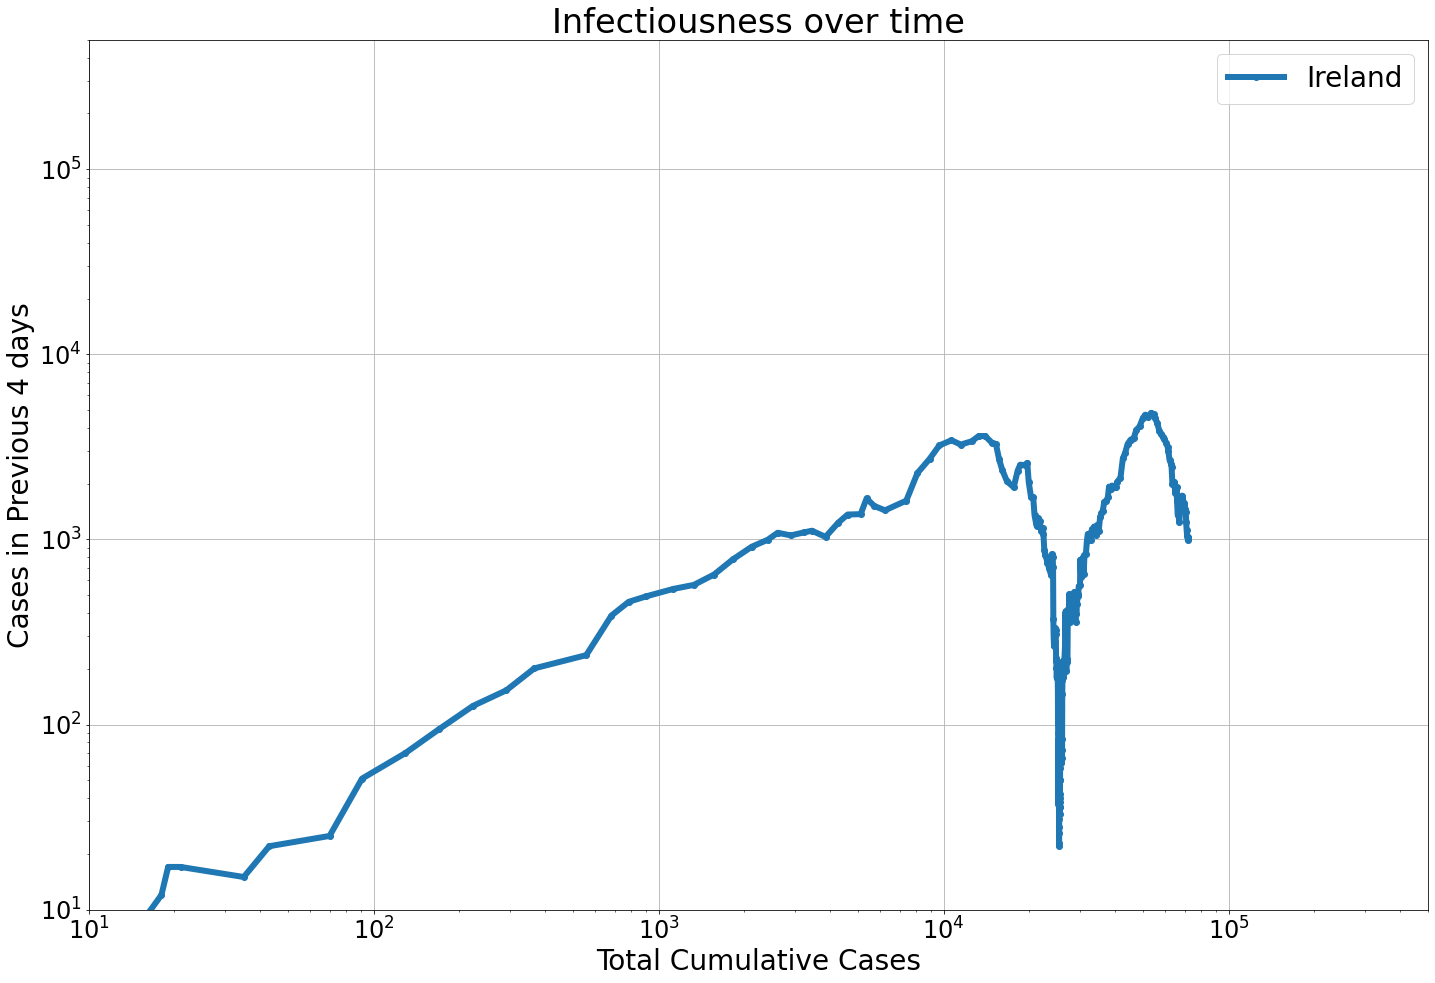

In [32]:

fig, ax = plt.subplots()
fig.set_size_inches(24, 16, forward=True)


# ax.plot(x1, r_0_list_1,   'o-', label = country1, linewidth=6)
# ax.plot(x2, r_0_list_2,   'o-', label = country2, linewidth=6)
# ax.plot(x3, r_0_list_3,   'o-', label = country3, linewidth=6)
# ax.plot(x4, r_0_list_4,   'o-', label = country4, linewidth=6)
ax.plot(x5, r_0_list_5,   'o-', label = country5, linewidth=6)
# ax.plot(x6, r_0_list_6,   'o-', label = country6, linewidth=6)
# ax.plot(x7, r_0_list_7,   'o-', label = country7, linewidth=6)
# ax.plot(x8, r_0_list_8,   'o-', label = country8, linewidth=6)
# ax.plot(x9, r_0_list_9,   'o-', label = country9, linewidth=6)
# ax.plot(x10, r_0_list_10,   'o-', label = country10, linewidth=6)


plt.rc('font', size=28)
#plt.xlabel('DATE', fontsize=20)
plt.ylabel("Cases in Previous 4 days", fontsize=28)
plt.xlabel("Total Cumulative Cases", fontsize=28)
#_ = plt.plot([0.01, 1], [0.01, 1])

plt.xticks(fontsize=24)
plt.xticks(rotation=0)

plt.yticks(fontsize=24)
plt.title(country, fontsize = 28)

plt.xlim(10,5e5)
plt.ylim(10,5e5)



plt.yscale('log')
plt.xscale('log')
plt.title('Infectiousness over time')

plt.legend()

plt.grid(True)
plt.show()

In [33]:
eu.groupby('COUNTRY').count().index.values

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua_and_Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius and Saba', 'Bosnia_and_Herzegovina',
       'Botswana', 'Brazil', 'British_Virgin_Islands',
       'Brunei_Darussalam', 'Bulgaria', 'Burkina_Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Canada', 'Cape_Verde',
       'Cases_on_an_international_conveyance_Japan', 'Cayman_Islands',
       'Central_African_Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo', 'Costa_Rica', 'Cote_dIvoire', 'Croatia',
       'Cuba', 'CuraÃ§ao', 'Cyprus', 'Czechia',
       'Democratic_Republic_of_the_Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican_Republic', 'Ecuador', 'Egypt',
       'El_Salvador', 'Equatorial_Guinea', 'Er

In [34]:
country1 = 'United_States_of_America'#'China'
country2 = 'Italy'
country3 = 'South_Korea'
country4 = 'Japan'
country5 = 'Ireland'
country6 = 'Spain'
country7 = 'France'
country8 = 'Iran'
country9 = 'United_Kingdom'
country10 = 'Netherlands' #'United States of America'

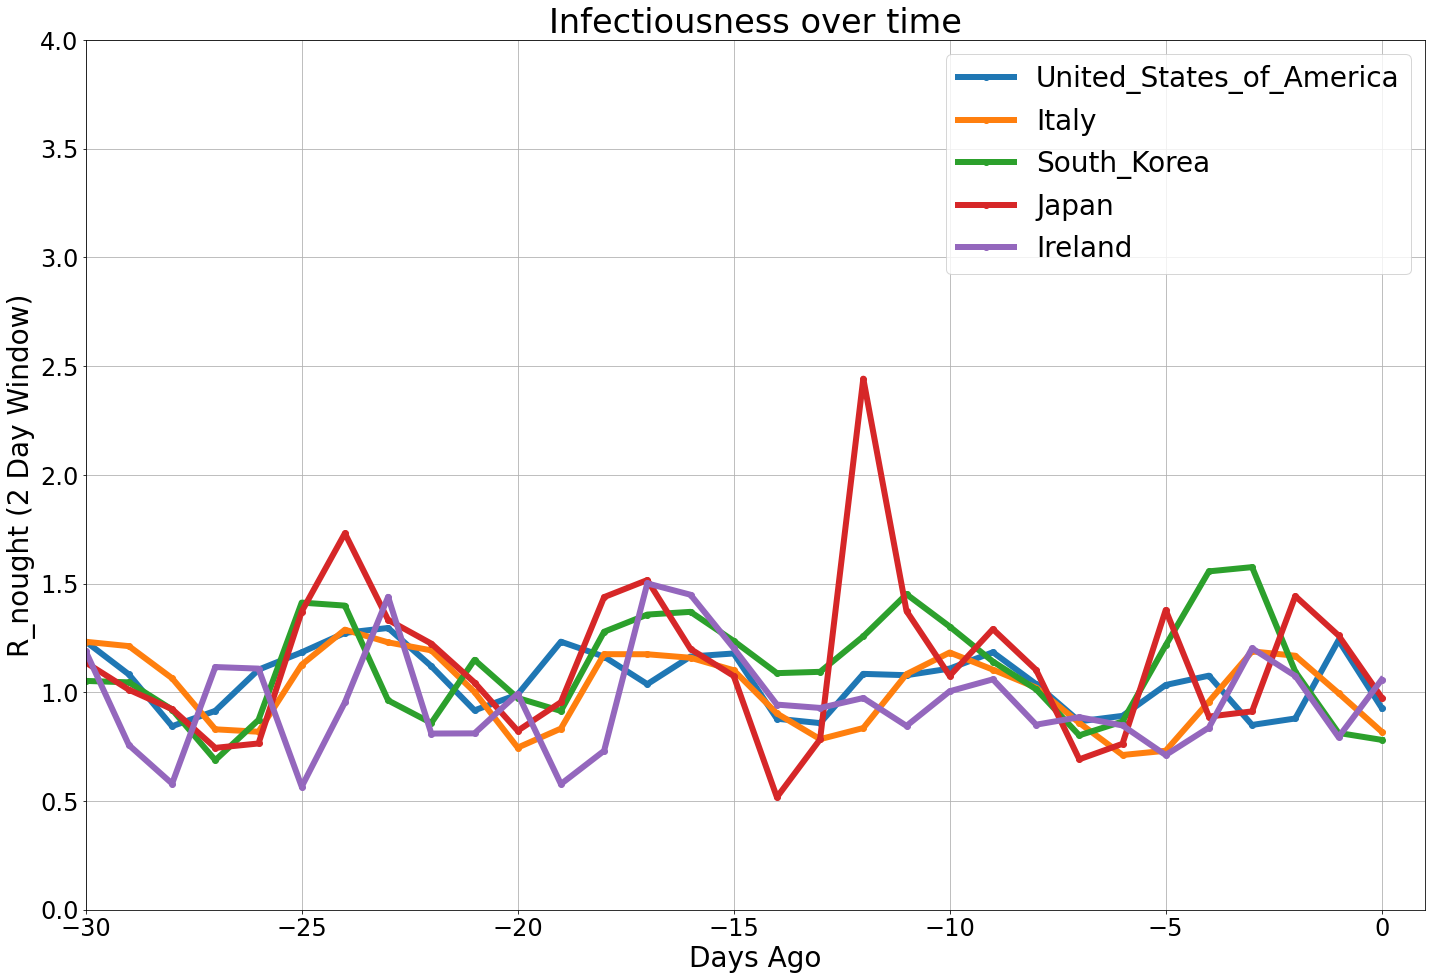

In [35]:

set1 = (eu[eu.COUNTRY == country1].sort_values(by = 'DATE').CASES).values
set2 = (eu[eu.COUNTRY == country2].sort_values(by = 'DATE').CASES).values
set3 = (eu[eu.COUNTRY == country3].sort_values(by = 'DATE').CASES).values
set4 = (eu[eu.COUNTRY == country4].sort_values(by = 'DATE').CASES).values
set5 = (eu[eu.COUNTRY == country5].sort_values(by = 'DATE').CASES).values
set6 = (eu[eu.COUNTRY == country6].sort_values(by = 'DATE').CASES).values
set7 = (eu[eu.COUNTRY == country7].sort_values(by = 'DATE').CASES).values
set8 = (eu[eu.COUNTRY == country8].sort_values(by = 'DATE').CASES).values
set9 = (eu[eu.COUNTRY == country9].sort_values(by = 'DATE').CASES).values
set10 = (eu[eu.COUNTRY == country10].sort_values(by = 'DATE').CASES).values



x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
x7 = []
x8 = []
x9 = []
x10 = []

r_0_list_1 = []
r_0_list_2 = []
r_0_list_3 = []
r_0_list_4 = []
r_0_list_5 = []
r_0_list_6 = []
r_0_list_7 = []
r_0_list_8 = []
r_0_list_9 = []
r_0_list_10 = []

for i in range(len(set1)):
    try:
        r_0_1 = (set1[-1-i] + set1[-2-i])/(set1[-3-i] + set1[-4-i])
    except:
        pass
    if r_0_1 == np.inf:
        r_0_1 = np.nan
    x = i*(-1)
    x1.append(x)
    r_0_list_1.append(r_0_1)
    
for i in range(len(set2)):
    try:
        r_0_2 = (set2[-1-i] + set2[-2-i])/(set2[-3-i] + set2[-4-i])
    except:
        pass
    if r_0_2 == np.inf:
        r_0_2 = np.nan
    x = i*(-1)
    x2.append(x)
    r_0_list_2.append(r_0_2)

for i in range(len(set3)):
    try:
        r_0_3 = (set3[-1-i] + set3[-2-i])/(set3[-3-i] + set3[-4-i])
    except:
        pass
    if r_0_3 == np.inf:
        r_0_3 = np.nan
    x = i*(-1)
    x3.append(x)
    r_0_list_3.append(r_0_3)
    
for i in range(len(set4)):
    try:
        r_0_4 = (set4[-1-i] + set4[-2-i])/(set4[-3-i] + set4[-4-i])
    except:
        pass
    if r_0_4 == np.inf:
        r_0_4 = np.nan
    x = i*(-1)
    x4.append(x)
    r_0_list_4.append(r_0_4)

for i in range(len(set5)):
    try:
        r_0_5 = (set5[-1-i] + set5[-2-i])/(set5[-3-i] + set5[-4-i])
    except:
        pass
    if r_0_5 == np.inf:
        r_0_5 = np.nan
    x = i*(-1)
    x5.append(x)
    r_0_list_5.append(r_0_5)
    
for i in range(len(set6)):
    try:
        r_0_6 = (set6[-1-i] + set6[-2-i])/(set6[-3-i] + set6[-4-i])
    except:
        pass
    if r_0_6 == np.inf:
        r_0_6 = np.nan
    x = i*(-1)
    x6.append(x)
    r_0_list_6.append(r_0_6)
     
for i in range(len(set7)):
    try:
        r_0_7 = (set7[-1-i] + set7[-2-i])/(set7[-3-i] + set7[-4-i])
    except:
        pass
    if r_0_7 == np.inf:
        r_0_7 = np.nan
    x = i*(-1)
    x7.append(x)
    r_0_list_7.append(r_0_7)
    
for i in range(len(set8)):
    try:
        r_0_8 = (set8[-1-i] + set8[-2-i])/(set8[-3-i] + set8[-4-i])
    except:
        pass
    if r_0_8 == np.inf:
        r_0_8 = np.nan
    x = i*(-1)
    x8.append(x)
    r_0_list_8.append(r_0_8)
    
for i in range(len(set9)):
    try:
        r_0_9 = (set9[-1-i] + set9[-2-i])/(set9[-3-i] + set9[-4-i])
    except:
        pass
    if r_0_9 == np.inf:
        r_0_9 = np.nan
    x = i*(-1)
    x9.append(x)
    r_0_list_9.append(r_0_9)
    
for i in range(len(set10)):
    try:
        r_0_10 = (set10[-1-i] + set10[-2-i])/(set10[-3-i] + set10[-4-i])
    except:
        pass
    if r_0_10 == np.inf:
        r_0_10 = np.nan
    x = i*(-1)
    x10.append(x)
    r_0_list_10.append(r_0_10)



fig, ax = plt.subplots()
fig.set_size_inches(24, 16, forward=True)


ax.plot(x1, r_0_list_1,   'o-', label = country1, linewidth=6)
ax.plot(x2, r_0_list_2,   'o-', label = country2, linewidth=6)
ax.plot(x3, r_0_list_3,   'o-', label = country3, linewidth=6)
ax.plot(x4, r_0_list_4,   'o-', label = country4, linewidth=6)
ax.plot(x5, r_0_list_5,   'o-', label = country5, linewidth=6)
#ax.plot(x6, r_0_list_6,   'o-', label = country6, linewidth=6)
#ax.plot(x7, r_0_list_7,   'o-', label = country7, linewidth=8)
#ax.plot(x8, r_0_list_8,   'o-', label = country8, linewidth=6)
# ax.plot(x9, r_0_list_9,   'o-', label = country9, linewidth=6)
# ax.plot(x10, r_0_list_10,   'o-', label = country10, linewidth=6)


plt.rc('font', size=28)
#plt.xlabel('DATE', fontsize=20)
plt.ylabel("R_nought (2 Day Window)", fontsize=28)
plt.xlabel("Days Ago", fontsize=28)
#_ = plt.plot([0.01, 1], [0.01, 1])

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title(country, fontsize = 28)

plt.xlim(-30 ,1)
plt.xticks(rotation=0)
plt.ylim(0,4)
#plt.yscale('log')
#plt.xscale('log')
plt.title('Infectiousness over time')

plt.legend()

plt.grid(True)
plt.show()

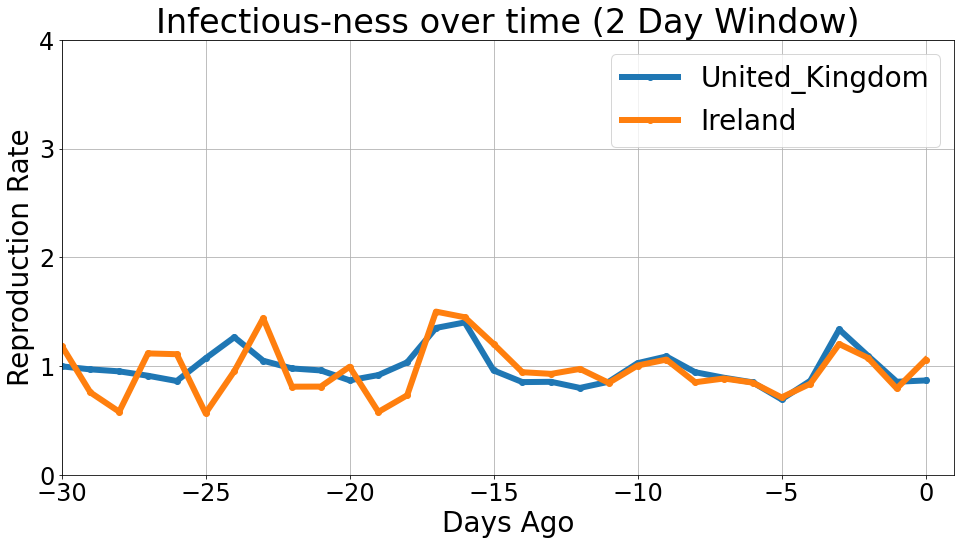

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8, forward=True)

ax.plot(x9, r_0_list_9,   'o-', label = country9, linewidth=6)
ax.plot(x5, r_0_list_5,   'o-', label = country5, linewidth=6)

plt.rc('font', size=28)
#plt.xlabel('DATE', fontsize=20)
plt.ylabel("Reproduction Rate", fontsize=28)
plt.xlabel("Days Ago", fontsize=28)
#_ = plt.plot([0.01, 1], [0.01, 1])

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title(country, fontsize = 28)

plt.xlim(-30 ,1)
plt.xticks(rotation=0)
plt.ylim(0,4)
#plt.yscale('log')
#plt.xscale('log')
plt.title('Infectious-ness over time (2 Day Window)')

plt.legend()

plt.grid(True)
plt.show()

In [37]:
eu[eu.COUNTRY == 'Jamaica']

,COUNTRY,DATE,day,month,year,CASES,DEATHS,countryterritoryCode,POPULATION,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,CUM_CASES,CUM_DEATHS,INFECTED_CUM_FRXN,AT_LEAST_5_DAILY_CASES_DATE,DAYS_SINCE_5_INFXNS,AT_LEAST_1_in_1e6_infected,DAYS_SINCE_INFXN_START
28047,Jamaica,2020-03-12,12,3,2020,2,0,JAM,2948277.0,America,NaN,2.0,0.0,6.783623e-07,2020-03-29,-17.0,2020-03-13,-1.0
28048,Jamaica,2020-03-13,13,3,2020,4,0,JAM,2948277.0,America,NaN,6.0,0.0,2.035087e-06,2020-03-29,-16.0,2020-03-13,0.0
28049,Jamaica,2020-03-14,14,3,2020,2,0,JAM,2948277.0,America,NaN,8.0,0.0,2.713449e-06,2020-03-29,-15.0,2020-03-13,1.0
28050,Jamaica,2020-03-16,16,3,2020,2,0,JAM,2948277.0,America,NaN,10.0,0.0,3.391812e-06,2020-03-29,-13.0,2020-03-13,3.0
28051,Jamaica,2020-03-17,17,3,2020,0,0,JAM,2948277.0,America,NaN,10.0,0.0,3.391812e-06,2020-03-29,-12.0,2020-03-13,4.0
28052,Jamaica,2020-03-18,18,3,2020,3,0,JAM,2948277.0,America,NaN,13.0,0.0,4.409355e-06,2020-03-29,-11.0,2020-03-13,5.0
28053,Jamaica,2020-03-19,19,3,2020,2,0,JAM,2948277.0,America,NaN,15.0,0.0,5.087717e-06,2020-03-29,-10.0,2020-03-13,6.0
28054,Jamaica,2020-03-20,20,3,2020,1,0,JAM,2948277.0,America,NaN,16.0,0.0,5.426898e-06,2020-03-29,-9.0,2020-03-13,7.0
28055,Jamaica,2020-03-21,21,3,2020,3,0,JAM,2948277.0,America,NaN,19.0,0.0,6.444442e-06,2020-03-29,-8.0,2020-03-13,8.0
28056,Jamaica,2020-03-22,22,3,2020,0,0,JAM,2948277.0,America,NaN,19.0,0.0,6.444442e-06,2020-03-29,-7.0,2020-03-13,9.0


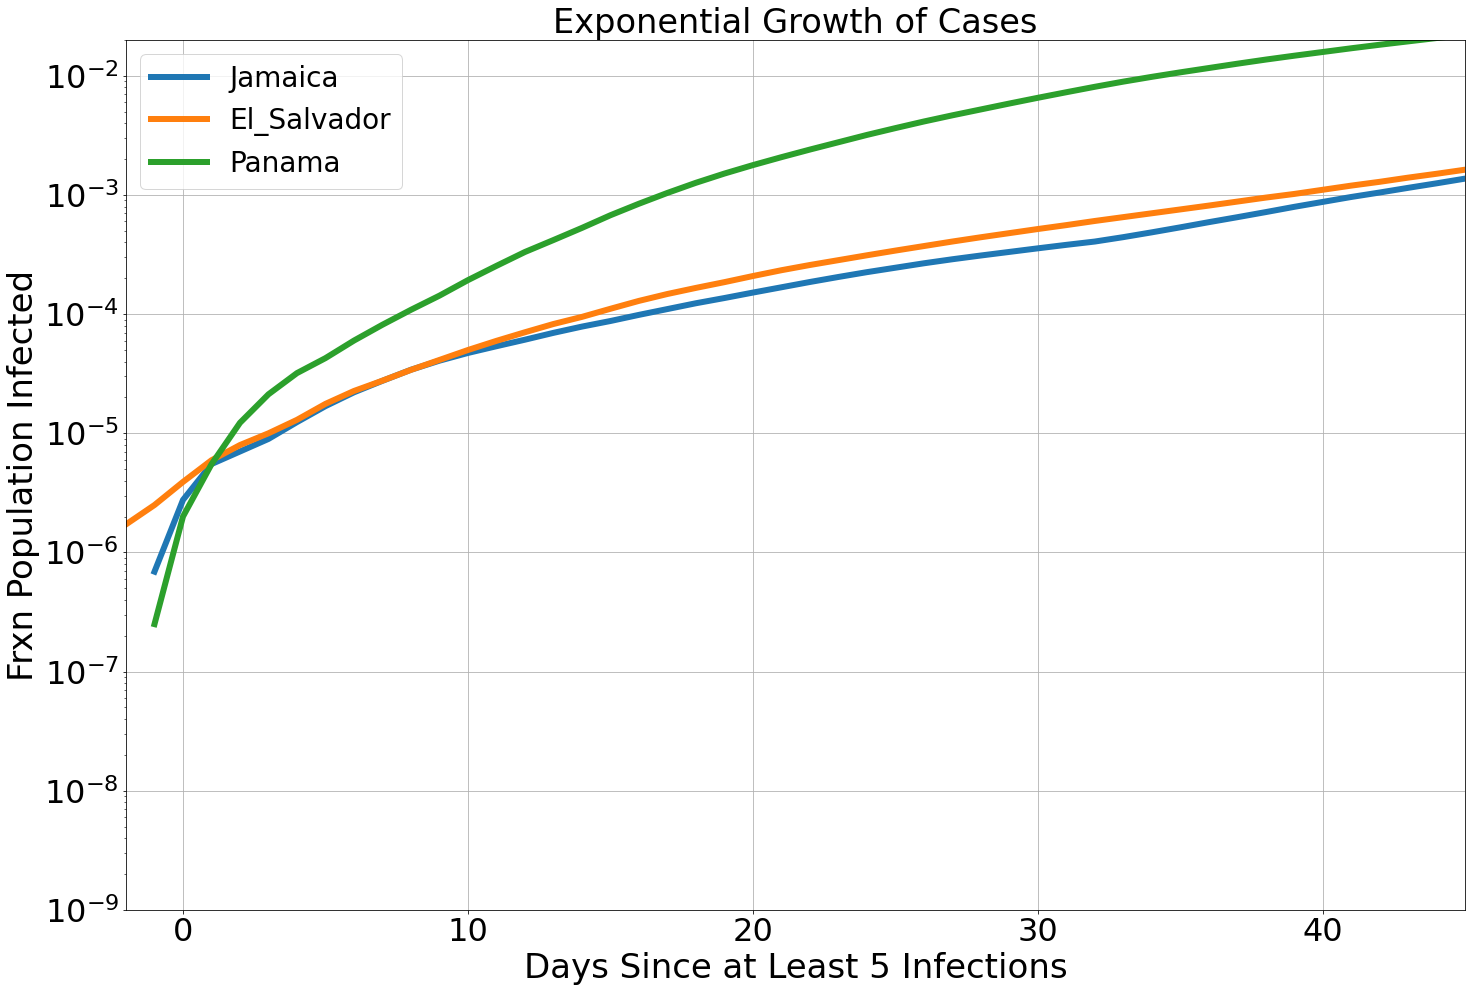

In [38]:
## DIGICEL COUNTRIES ##### DIGICEL COUNTRIES ##### DIGICEL COUNTRIES ##### DIGICEL COUNTRIES ##### DIGICEL COUNTRIES ###

country1 = 'Jamaica'
country2 = 'El_Salvador'
country3 = 'Panama'


pop1 = 2.9e6
pop2 = 6.4e6
pop3 = 4e6


set1 = np.cumsum(eu[eu.COUNTRY == country1].sort_values(by = 'DATE').CUM_CASES).values
x1 = eu[eu.COUNTRY == country1].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values

set2 = np.cumsum(eu[eu.COUNTRY == country2].sort_values(by = 'DATE').CUM_CASES).values
x2 = eu[eu.COUNTRY == country2].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values

set3 = np.cumsum(eu[eu.COUNTRY == country3].sort_values(by = 'DATE').CUM_CASES).values
x3 = eu[eu.COUNTRY == country3].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values

fig, ax = plt.subplots()
fig.set_size_inches(24, 16, forward=True)

ax.plot(x1,  np.divide(set1,pop1),   '-', label = country1, linewidth=6)
ax.plot(x2,  np.divide(set2,pop2),   '-', label = country2, linewidth=6)
ax.plot(x3,  np.divide(set3,pop3),   '-', label = country3, linewidth=6)


plt.rc('font', size=28)
#plt.xlabel('DATE', fontsize=20)
plt.ylabel("Frxn Population Infected", fontsize=34)
plt.xlabel("Days Since at Least 5 Infections", fontsize=34)
#_ = plt.plot([0.01, 1], [0.01, 1])

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.title(country, fontsize = 34)

plt.xlim(-2 ,45)
plt.xticks(rotation=0)
plt.ylim(1e-9,0.02)
plt.yscale('log')
#plt.xscale('log')
plt.title('Exponential Growth of Cases')

plt.legend()

plt.grid(True)
plt.show()

# Gompertz Fit

In [64]:
#import statsmodels
from statsmodels.api import OLS
from statsmodels.tools.tools import add_constant
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from lmfit import Model

In [65]:
country1 = 'United_States_of_America'#'China'
country2 = 'Italy'
country3 = 'South_Korea'
country4 = 'Japan'
country5 = 'Ireland'
country6 = 'Spain'
country7 = 'France'
country8 = 'Iran'
country9 = 'United_Kingdom'
country10 = 'China' #'United States of America'

In [66]:
abs1  = np.cumsum(eu[eu.COUNTRY == country1].sort_values(by = 'DATE').CASES).values
abs2  = np.cumsum(eu[eu.COUNTRY == country2].sort_values(by = 'DATE').CASES).values
abs3  = np.cumsum(eu[eu.COUNTRY == country3].sort_values(by = 'DATE').CASES).values
abs4  = np.cumsum(eu[eu.COUNTRY == country4].sort_values(by = 'DATE').CASES).values
abs5  = np.cumsum(eu[eu.COUNTRY == country5].sort_values(by = 'DATE').CASES).values
abs6  = np.cumsum(eu[eu.COUNTRY == country6].sort_values(by = 'DATE').CASES).values
abs7  = np.cumsum(eu[eu.COUNTRY == country7].sort_values(by = 'DATE').CASES).values
abs8  = np.cumsum(eu[eu.COUNTRY == country8].sort_values(by = 'DATE').CASES).values
abs9  = np.cumsum(eu[eu.COUNTRY == country9].sort_values(by = 'DATE').CASES).values
abs10 = np.cumsum(eu[eu.COUNTRY == country10].sort_values(by = 'DATE').CASES).values

x1  = eu[eu.COUNTRY == country1].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x2  = eu[eu.COUNTRY == country2].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x3  = eu[eu.COUNTRY == country3].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x4  = eu[eu.COUNTRY == country4].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x5  = eu[eu.COUNTRY == country5].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x6  = eu[eu.COUNTRY == country6].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x7  = eu[eu.COUNTRY == country7].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x8  = eu[eu.COUNTRY == country8].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x9  = eu[eu.COUNTRY == country9].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x10 = eu[eu.COUNTRY == country10].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values

In [67]:
def func_gomp(x, N0, a, c):
    return N0*np.exp((a/c)*(1-np.exp(-c*x)))

country1 = 'Ireland'
pop = 1000000 * 60

#days = 70

#conf = np.cumsum(eu[(eu.COUNTRY == country1) & (eu.CASES > 0)].sort_values(by = 'DATE').CASES).values

#conf = conf#/pop

#conf_trunc = conf[:days]
x = np.arange(len(abs5))
#x = add_constant(x)
#x_trunc = x[:days]

popt, pcov = curve_fit(func_gomp, x5, abs5)
perr = np.sqrt(np.diag(pcov))

x_fut = np.arange(100)
x_fut = add_constant(x_fut)

conf_pred = func_gomp(x_fut, popt[0], popt[1], popt[2])

fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.plot(x5, abs5, ".-", label="Reported cases " + country1, linewidth=6)
#conf_pred = pred#logistic_function(x, a_, b_, c_, d_)

#plt.plot(x[:,1], result.best_fit, label="Fitted logistic function")

mlx = MultipleLocator(2.5)
ax.xaxis.set_minor_locator(mlx)
ax.xaxis.grid(which="minor", color='k', linestyle='-', linewidth=0.7)

mly = MultipleLocator(10)
ax.yaxis.set_minor_locator(mly)
ax.yaxis.grid(which="major", color='k', linestyle='-', linewidth=0.7)


plt.plot(x_fut[:,1], conf_pred[:,1], "--", label="Gompertz Growth Model", linewidth=3)

bound_upper = func_gomp(x_fut, *(popt + perr))
bound_lower = func_gomp(x_fut, *(popt - perr))

plt.plot(x_fut, bound_upper, "--", linewidth=2)
plt.plot(x_fut, bound_lower, "--", linewidth=2)

plt.ylabel("Cumulative Count Infected", fontsize=24)
plt.xlabel("Days (since crossing 1 in a Million Infected)", fontsize=24)
plt.yscale('log')

plt.xlim(-5,60)
plt.ylim(1e-1,2e4)

plt.legend(fontsize=24)
plt.show()

popt

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

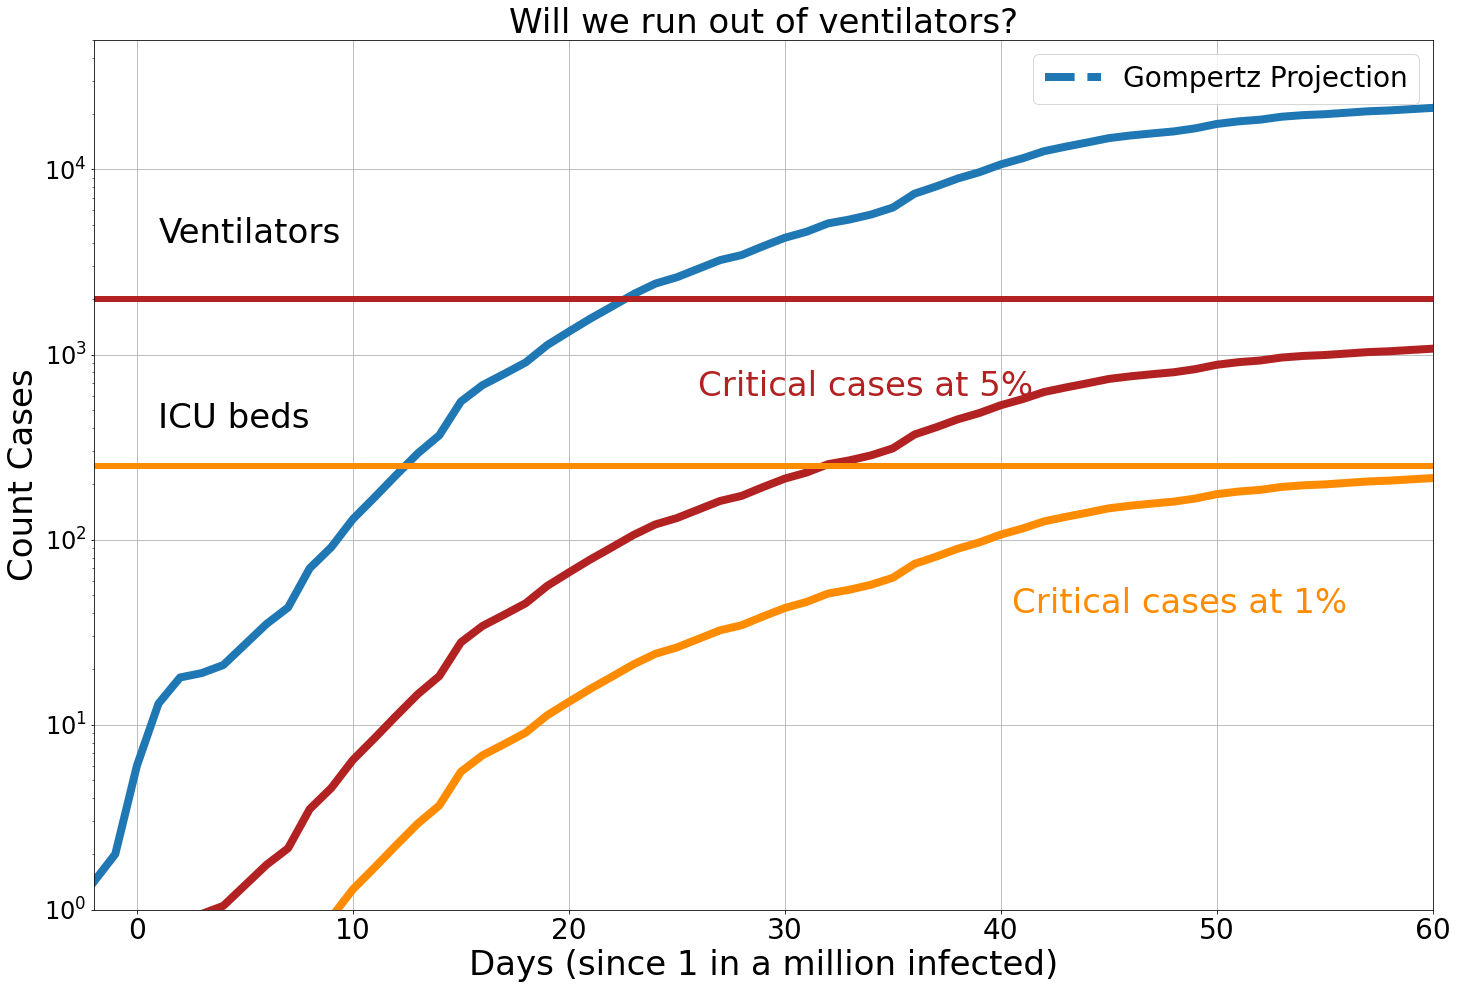

In [68]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 16, forward=True)

ax.plot(x5, abs5,   '-', color='tab:blue', linewidth=8)
ax.plot(x5, np.divide(abs5,20),   '-', color='firebrick', linewidth=8)
ax.plot(x5, np.divide(abs5,100),   '-', color='darkorange', linewidth=8)

plt.plot(x_fut[:,1], conf_pred[:,1], "--",color='tab:blue', label="Gompertz Projection", linewidth=8)
plt.plot(x_fut[:,1], np.divide(conf_pred[:,1],20), "--", color='firebrick', linewidth=8)
plt.plot(x_fut[:,1], np.divide(conf_pred[:,1],100), "--", color='darkorange', linewidth=8)

plt.rc('font', size=28)
#plt.xlabel('DATE', fontsize=20)
plt.ylabel("Count Cases", fontsize=34)
plt.xlabel("Days (since 1 in a million infected)", fontsize=34)

_ = plt.plot([-10, 60], [2000, 2000], linewidth=6,color='firebrick')  # number of ventilators
_ = plt.plot([-10, 60], [250, 250], linewidth=6,color='darkorange')  # number of ICU beds

y2 = 90000
#_ = plt.plot([0, 35], [8, y2], linewidth=4)  # number of cases
#_ = plt.plot([0, 35], [0.08, y2/100], linewidth=4)  # number of critical cases @ 1% critical rate
#_ = plt.plot([0, 35], [0.4, y2/20], linewidth=4)  # number of critical cases @ 5% critical rate


#plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.title(country, fontsize = 28)

# ml = MultipleLocator(2.5)
# ax.xaxis.set_minor_locator(ml)
# ax.xaxis.grid(which="minor", color='k', linestyle='-', linewidth=0.7)

# ml = MultipleLocator(0.1)
# ax.yaxis.set_minor_locator(ml)
# ax.yaxis.grid(which="minor", color='k', linestyle='-', linewidth=0.7)

plt.xlim(-2 ,60)
#plt.xticks(rotation=0)
plt.ylim(1,50000)
plt.yscale('log')
#plt.xscale('log')
plt.title("Will we run out of ventilators?", fontsize=34)

plt.text(26, 600, 'Critical cases at 5%', color='firebrick', fontsize=34)
plt.text(40.5, 40, 'Critical cases at 1%', color='darkorange', fontsize=34)

plt.text(1, 4000, 'Ventilators', fontsize=34)
plt.text(1, 400, 'ICU beds', fontsize=34)

plt.legend()

plt.grid(True)
plt.show()

# Logistic Fit

In [69]:
#import statsmodels
from statsmodels.api import OLS
from statsmodels.tools.tools import add_constant
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from lmfit import Model

In [70]:
def func(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

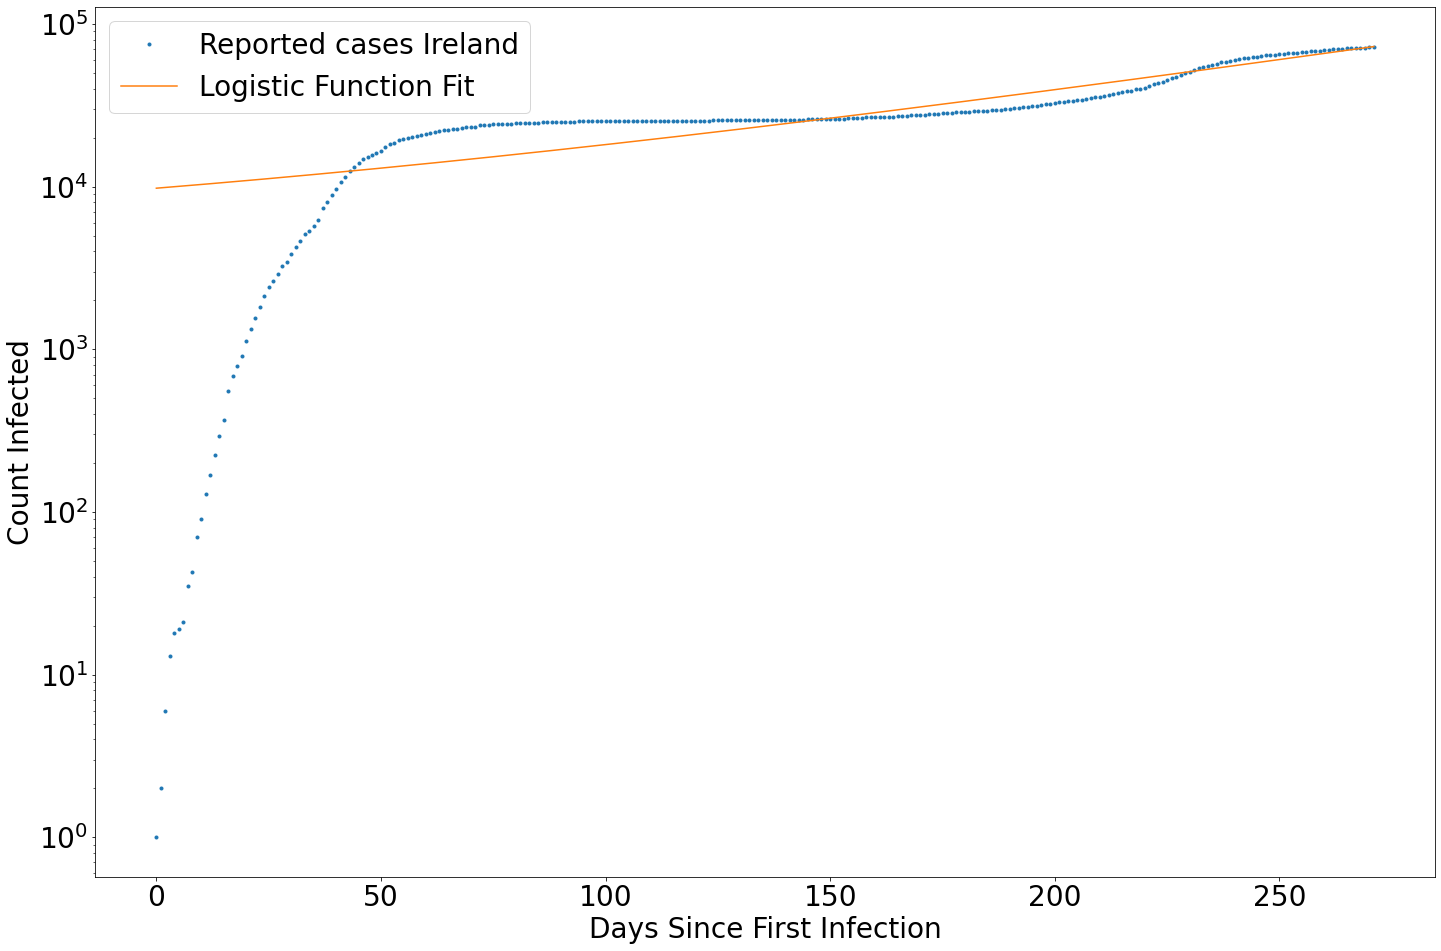

R-Squared  0.8928547492418883

a (limit of cases) 849438867.7226014
b  4409.983516773437
c (steepness)      0.009377707667942235
d (midpoint)       1276.4713934464914


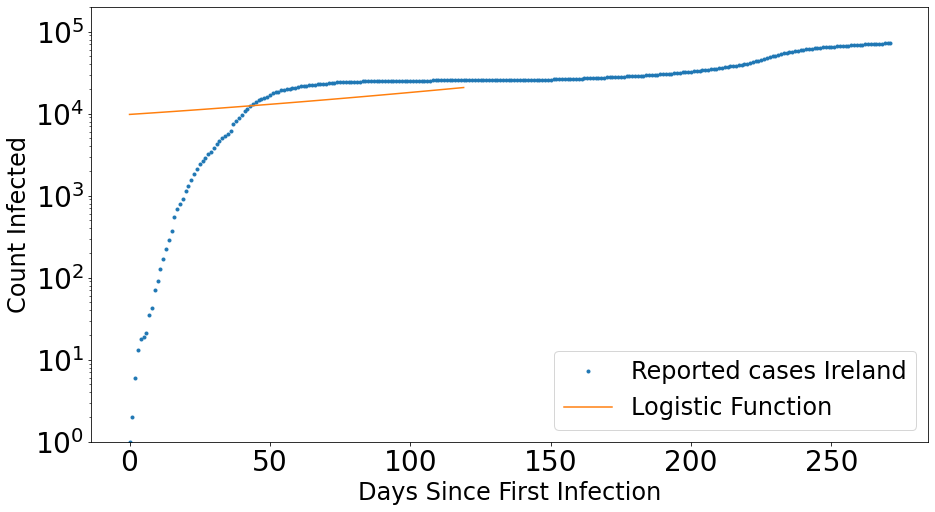

In [71]:
country1 = 'Ireland'

#days = 70

conf = np.cumsum(eu[(eu.COUNTRY == country1) & (eu.CASES > 0)].sort_values(by = 'DATE').CASES).values
#conf_trunc = conf[:days]
x = np.arange(len(conf))
x = add_constant(x)
#x_trunc = x[:days]

#conf += 1

# create model
fmodel = Model(func)
# create parameters -- these are named from the function arguments --
# giving initial values
params = fmodel.make_params(a=conf[-1], b=0, c=0, d=0)

result = fmodel.fit(conf, params, x=x[:,1])

result.params

fig, ax = plt.subplots()
fig.set_size_inches(24, 16, forward=True)

plt.plot(x[:,1], conf, ".", label="Reported cases " + country1)
#conf_pred = pred#logistic_function(x, a_, b_, c_, d_)

plt.plot(x[:,1], result.best_fit, label="Logistic Function Fit")

plt.ylabel("Count Infected", fontsize=28)
plt.xlabel("Days Since First Infection", fontsize=28)
plt.yscale('log')
plt.legend()
plt.show()



print ('R-Squared ', r2_score(conf, result.best_fit))
print ('')

print ('a (limit of cases)', result.best_values.get('a'))
print ('b ', result.best_values.get('b'))
print ('c (steepness)     ', result.best_values.get('c'))
print ('d (midpoint)      ', result.best_values.get('d'))

a = result.best_values.get('a')
b = result.best_values.get('b')
c = result.best_values.get('c')
d = result.best_values.get('d')

x_fut = np.arange(120)
x_fut = add_constant(x_fut)

conf_pred = func(x_fut, a, b, c, d)

fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.plot(x[:,1], conf, ".", label="Reported cases " + country1)
#conf_pred = pred#logistic_function(x, a_, b_, c_, d_)

#plt.plot(x[:,1], result.best_fit, label="Fitted logistic function")

plt.plot(x_fut[:,1], conf_pred[:,1], label="Logistic Function")

plt.ylabel("Count Infected", fontsize=24)
plt.xlabel("Days Since First Infection", fontsize=24)
plt.yscale('log')
plt.ylim(1, 200000)
plt.legend(fontsize=24)
plt.show()

# Generalised Growth Model

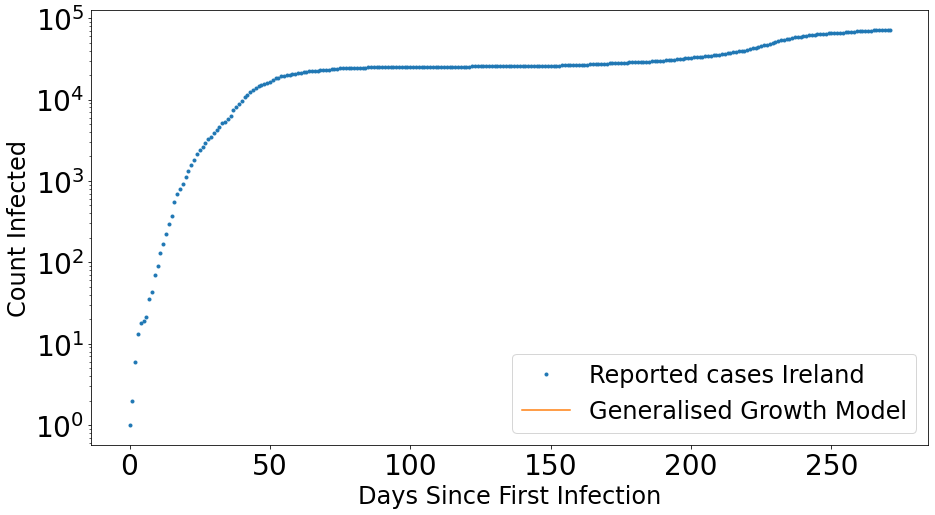

array([1., 1., 1.])

In [72]:
def func_ggm(x, a, r, p):
    return ((p-1)*(a-(r*x)))**(1/(1-p))


country1 = 'Ireland'

#days = 70

conf = np.cumsum(eu[(eu.COUNTRY == country1) & (eu.CASES > 0)].sort_values(by = 'DATE').CASES).values
#conf_trunc = conf[:days]
x = np.arange(len(conf))
#x = add_constant(x)
#x_trunc = x[:days]

popt, pcov = curve_fit(func_ggm, x, conf)

x_fut = np.arange(120)
x_fut = add_constant(x_fut)

conf_pred = func_ggm(x_fut, popt[0],popt[1],popt[2])

fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.plot(x, conf, ".", label="Reported cases " + country1)
#conf_pred = pred#logistic_function(x, a_, b_, c_, d_)

#plt.plot(x[:,1], result.best_fit, label="Fitted logistic function")

plt.plot(x_fut[:,1], conf_pred[:,1], label="Generalised Growth Model")

plt.ylabel("Count Infected", fontsize=24)
plt.xlabel("Days Since First Infection", fontsize=24)
plt.yscale('log')
plt.legend(fontsize=24)
plt.show()

popt

# Generalised Logistic Growth Model

In [73]:
def func_ggm(x, a, r, K):
    #p = 0.3
    return (K/(1+((K-(a**0.3))/(a**0.3)) * np.exp(-r*x)))**-0.3

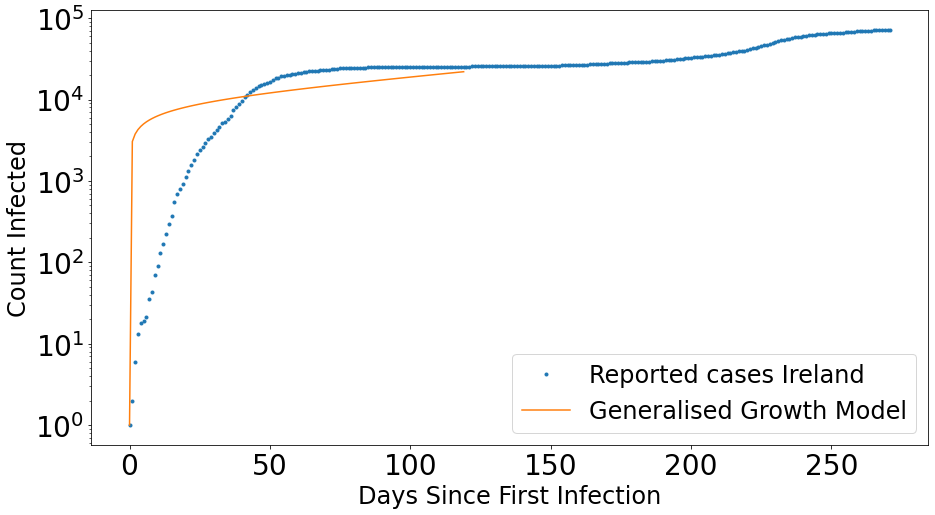

array([ 9.99610441e-01, -2.48605975e-02, -6.12873322e-14])

In [74]:
country1 = 'Ireland'

#days = 70

conf = np.cumsum(eu[(eu.COUNTRY == country1) & (eu.CASES > 0)].sort_values(by = 'DATE').CASES).values
#conf_trunc = conf[:days]
x = np.arange(len(conf))
#x = add_constant(x)
#x_trunc = x[:days]

popt, pcov = curve_fit(func_ggm, x, conf)

x_fut = np.arange(120)
x_fut = add_constant(x_fut)

conf_pred = func_ggm(x_fut, popt[0],popt[1],popt[2])

fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.plot(x, conf, ".", label="Reported cases " + country1)
#conf_pred = pred#logistic_function(x, a_, b_, c_, d_)

#plt.plot(x[:,1], result.best_fit, label="Fitted logistic function")

plt.plot(x_fut[:,1], conf_pred[:,1], label="Generalised Growth Model")

plt.ylabel("Count Infected", fontsize=24)
plt.xlabel("Days Since First Infection", fontsize=24)
plt.yscale('log')
plt.legend(fontsize=24)
plt.show()

popt

In [75]:
def func_gglm(x,b,p,K):
    return 100 + ((b*x**p) * (1 - (x/K)))

In [76]:
def func_exp(x, b, c, d):
    return np.exp(c * (x-d)) + b

country1 = 'Ireland'

#days = 70

conf = np.cumsum(eu[(eu.COUNTRY == country1) & (eu.CASES > 0)].sort_values(by = 'DATE').CASES).values
#conf_trunc = conf[:days]
x = np.arange(len(conf))
#x = add_constant(x)
#x_trunc = x[:days]

popt, pcov = curve_fit(func_exp, x, conf)
perr = np.sqrt(np.diag(pcov))

x_fut = np.arange(100)
x_fut = add_constant(x_fut)

conf_pred = func_exp(x_fut, popt[0], popt[1], popt[2])

fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.plot(x, conf, ".", label="Reported cases " + country1)
#conf_pred = pred#logistic_function(x, a_, b_, c_, d_)

#plt.plot(x[:,1], result.best_fit, label="Fitted logistic function")

plt.plot(x_fut[:,1], conf_pred[:,1], label="Generalised Logistic Growth Model")

bound_upper = func_exp(x_fut, *(popt + perr))
bound_lower = func_exp(x_fut, *(popt - perr))

plt.plot(x_fut, bound_upper)
plt.plot(x_fut, bound_lower)

plt.ylabel("Count Infected", fontsize=24)
plt.xlabel("Days Since First Infection", fontsize=24)
plt.yscale('log')
plt.legend(fontsize=24)
plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

# Polynomial Fit

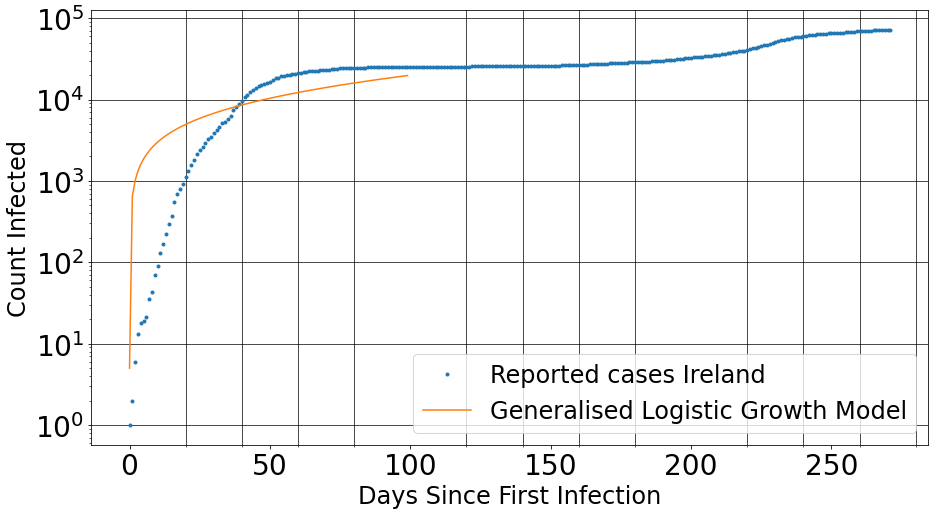

In [77]:
def func_poly(x,b,p,K):
    return 5 + ((b*x**p) * (1 - (x/K)))

country1 = 'Ireland'

#days = 70

conf = np.cumsum(eu[(eu.COUNTRY == country1) & (eu.CASES > 0)].sort_values(by = 'DATE').CASES).values
#conf_trunc = conf[:days]
x = np.arange(len(conf))
#x = add_constant(x)
#x_trunc = x[:days]

popt, pcov = curve_fit(func_poly, x, conf)
perr = np.sqrt(np.diag(pcov))

x_fut = np.arange(100)
x_fut = add_constant(x_fut)

conf_pred = func_poly(x_fut, popt[0], popt[1], popt[2])

fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.plot(x, conf, ".", label="Reported cases " + country1)
#conf_pred = pred#logistic_function(x, a_, b_, c_, d_)

#plt.plot(x[:,1], result.best_fit, label="Fitted logistic function")

mlx = MultipleLocator(20)
ax.xaxis.set_minor_locator(mlx)
ax.xaxis.grid(which="minor", color='k', linestyle='-', linewidth=0.7)

mly = MultipleLocator(10)
ax.yaxis.set_minor_locator(mly)
ax.yaxis.grid(which="major", color='k', linestyle='-', linewidth=0.7)

plt.plot(x_fut[:,1], conf_pred[:,1], label="Generalised Logistic Growth Model")

bound_upper = func_poly(x_fut, *(popt + perr))
bound_lower = func_poly(x_fut, *(popt - perr))

#_ = plt.plot([18, 18], [18, 400000], linewidth=2)  # number of ventilators
#_ = plt.plot([0, 35], [40, 3000000], linewidth=2)
#plt.plot(x_fut, bound_upper)
#plt.plot(x_fut, bound_lower)

plt.ylabel("Count Infected", fontsize=24)
plt.xlabel("Days Since First Infection", fontsize=24)
plt.yscale('log')
#plt.ylim(100, 200000)
#plt.xlim(1,70)
plt.legend(fontsize=24)
plt.show()

In [78]:
popt

array([ 636.36166325,    0.64776321, -170.77459347])

In [79]:
eu[eu.COUNTRY == 'China']

,COUNTRY,DATE,day,month,year,CASES,DEATHS,countryterritoryCode,POPULATION,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,CUM_CASES,CUM_DEATHS,INFECTED_CUM_FRXN,AT_LEAST_5_DAILY_CASES_DATE,DAYS_SINCE_5_INFXNS,AT_LEAST_1_in_1e6_infected,DAYS_SINCE_INFXN_START
11513,China,2019-12-31,31,12,2019,27,0,CHN,1.433784e+09,Asia,NaN,27.0,0.0,1.883129e-08,2019-12-31,0.0,2020-01-26,-26.0
11514,China,2020-01-01,1,1,2020,0,0,CHN,1.433784e+09,Asia,NaN,27.0,0.0,1.883129e-08,2019-12-31,1.0,2020-01-26,-25.0
11515,China,2020-01-02,2,1,2020,0,0,CHN,1.433784e+09,Asia,NaN,27.0,0.0,1.883129e-08,2019-12-31,2.0,2020-01-26,-24.0
11516,China,2020-01-03,3,1,2020,17,0,CHN,1.433784e+09,Asia,NaN,44.0,0.0,3.068803e-08,2019-12-31,3.0,2020-01-26,-23.0
11517,China,2020-01-04,4,1,2020,0,0,CHN,1.433784e+09,Asia,NaN,44.0,0.0,3.068803e-08,2019-12-31,4.0,2020-01-26,-22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11844,China,2020-11-26,26,11,2020,21,0,CHN,1.433784e+09,Asia,0.012275,91779.0,4739.0,6.401175e-05,2019-12-31,331.0,2020-01-26,305.0
11845,China,2020-11-27,27,11,2020,5,0,CHN,1.433784e+09,Asia,0.012624,91784.0,4739.0,6.401524e-05,2019-12-31,332.0,2020-01-26,306.0
11846,China,2020-11-28,28,11,2020,6,0,CHN,1.433784e+09,Asia,0.011996,91790.0,4739.0,6.401942e-05,2019-12-31,333.0,2020-01-26,307.0
11847,China,2020-11-29,29,11,2020,6,0,CHN,1.433784e+09,Asia,0.011647,91796.0,4739.0,6.402360e-05,2019-12-31,334.0,2020-01-26,308.0


# Multi Polynomial Fit

In [80]:
def func_poly(x, a,b,c,d):
    return a + b*x + (c*x**2) + (d*x**3)

country1 = 'Ireland'

#days = 70

conf = np.cumsum(eu[(eu.COUNTRY == country1) & (eu.CASES > 0)].sort_values(by = 'DATE').CASES).values
#conf_trunc = conf[:days]
x = np.arange(len(conf))
x = add_constant(x)
#x_trunc = x[:days]

#conf += 1

# create model
pmodel = Model(func_poly)
# create parameters -- these are named from the function arguments --
# giving initial values
params = pmodel.make_params(a=0, b=0, c=0, d=0)

result = pmodel.fit(conf, params, x=x[:,1])

result.params

name,value,standard error,relative error,initial value,min,max,vary
a,-8348.68191,682.786463,(8.18%),0,-inf,inf,True
b,750.029906,21.8597952,(2.91%),0,-inf,inf,True
c,-5.81253297,0.18763767,(3.23%),0,-inf,inf,True
d,0.01571342,4.5509e-04,(2.90%),0,-inf,inf,True


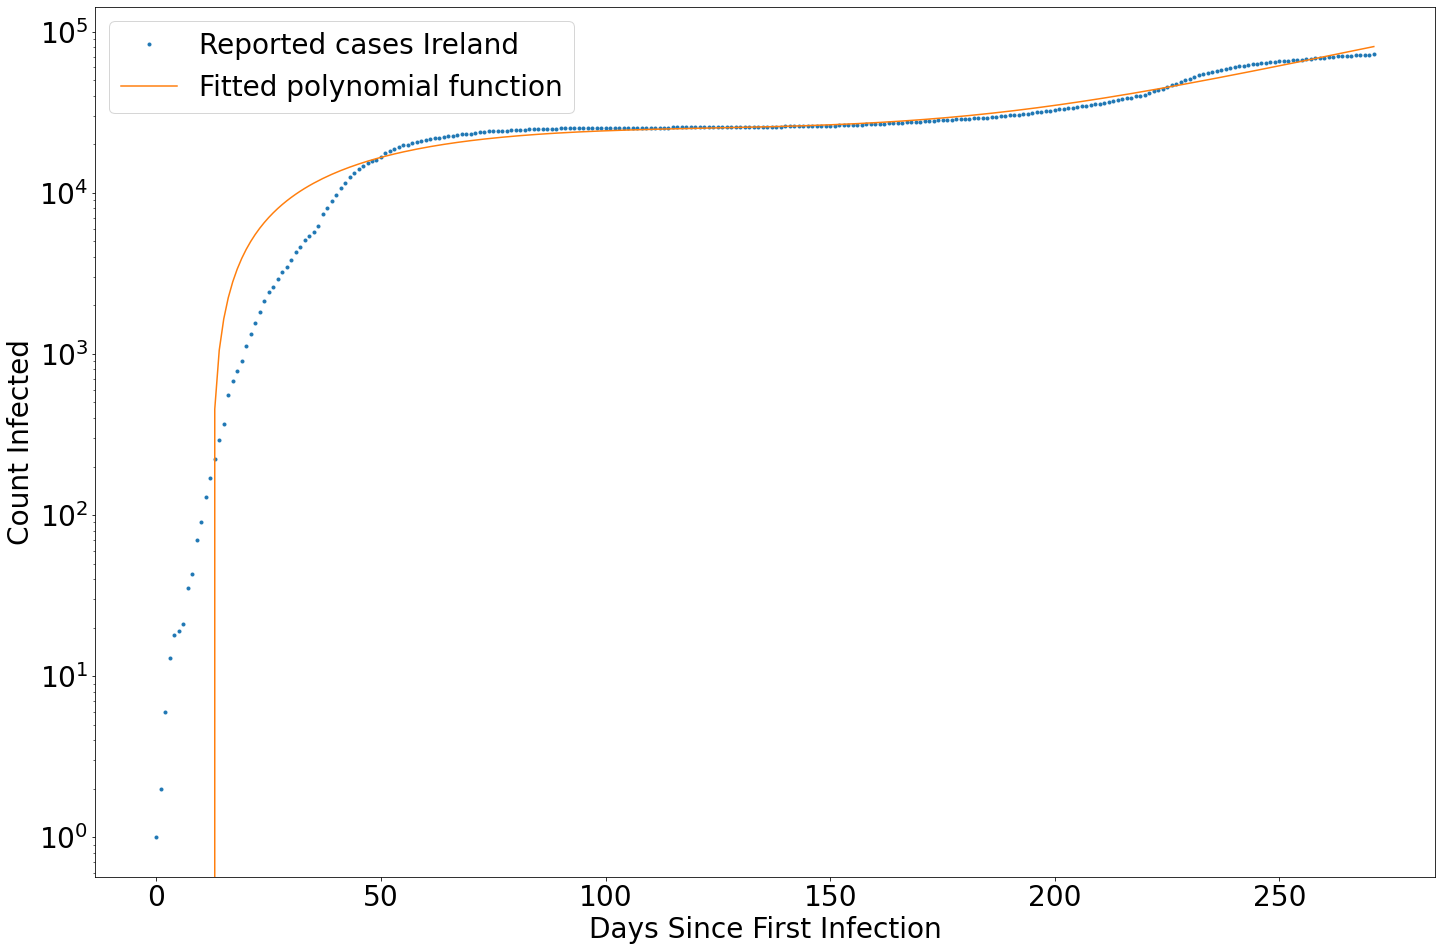

In [81]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 16, forward=True)

plt.plot(x[:,1], conf, ".", label="Reported cases " + country1)
#conf_pred = pred#logistic_function(x, a_, b_, c_, d_)

plt.plot(x[:,1], result.best_fit, label="Fitted polynomial function")

plt.ylabel("Count Infected", fontsize=28)
plt.xlabel("Days Since First Infection", fontsize=28)
plt.yscale('log')
plt.legend()
plt.show()

In [82]:
print ('R-Squared ', r2_score(conf, result.best_fit))
print ('')

print ('a (limit of cases)', result.best_values.get('a'))
print ('b ', result.best_values.get('b'))
print ('c (steepness)     ', result.best_values.get('c'))
#print ('d (midpoint)      ', result.best_values.get('d'))

R-Squared  0.9762554037148169

a (limit of cases) -8348.681907662063
b  750.0299055858687
c (steepness)      -5.812532974949711


In [83]:
a = result.best_values.get('a')
b = result.best_values.get('b')
c = result.best_values.get('c')
d = result.best_values.get('d')

TypeError: func_poly() missing 1 required positional argument: 'd'

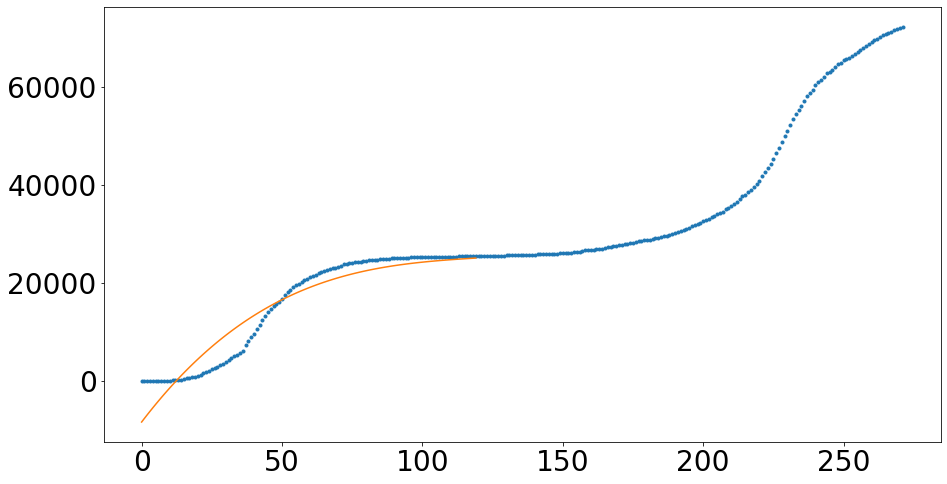

In [84]:
x_fut = np.arange(120)
x_fut = add_constant(x_fut)

conf_pred = func_poly(x_fut, a,b,c,d)

fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.plot(x[:,1], conf, ".", label="Reported cases " + country1)
#conf_pred = pred#logistic_function(x, a_, b_, c_, d_)

#plt.plot(x[:,1], result.best_fit, label="Fitted logistic function")

plt.plot(x_fut[:,1], conf_pred[:,1], label="Extrapolated polynomial function")

bound_upper = func_poly(x_fut, *(popt + perr))
bound_lower = func_poly(x_fut, *(popt - perr))

plt.plot(x_fut, bound_upper)
plt.plot(x_fut, bound_lower)


plt.ylabel("Count Infected", fontsize=24)
plt.xlabel("Days Since First Infection", fontsize=24)
plt.yscale('log')
plt.legend(fontsize=24)
plt.show()

# Exponential Fit

In [85]:
conf = np.cumsum(eu[eu.COUNTRY == 'China'].sort_values(by = 'DATE').CASES).values
x = np.arange(len(conf))
x = add_constant(x)

conf = conf + 0.1

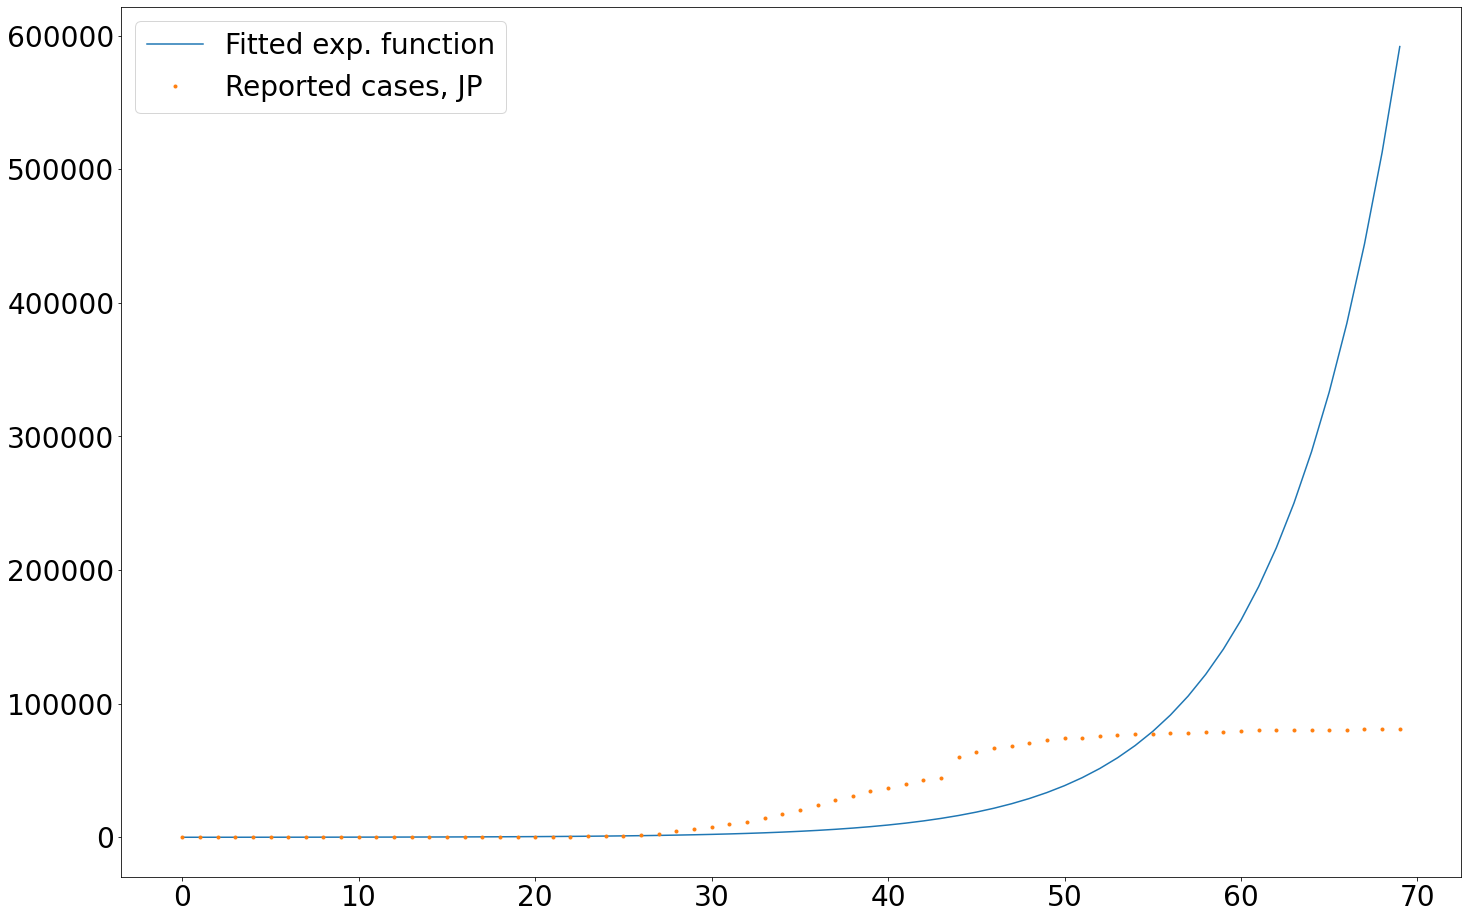

In [86]:
days = 70
model = OLS(np.log(conf[:days]), x[:days]) # First two weeks
#model = OLS(np.log(conf), x) # Full data

result = model.fit()

result.summary()

fig, ax = plt.subplots()
fig.set_size_inches(24, 16, forward=True)

plt.plot(
    np.exp(result.predict(x[:days])),
    label="Fitted exp. function"      
)
plt.plot(conf[:days], ".", label="Reported cases, JP")
plt.legend()
plt.show()

In [87]:
# from lmfit import Parameters, minimize
# from lmfit.printfuncs import report_fit

# p_true = Parameters()
# p_true.add('a', value=14.0)
# p_true.add('b', value=5.4321)
# p_true.add('p', value=0.12345)
# p_true.add('decay', value=0.01000)

# conf = np.cumsum(eu[(eu.COUNTRY == country1) & (eu.CASES > 0)].sort_values(by = 'DATE').CASES).values
# x = np.arange(len(conf))

# fit_params = Parameters()
# fit_params.add('a', value=13.0, max=20, min=0.0)
# fit_params.add('b', value=1, max=100)
# fit_params.add('p', value=0.0, max=1, min=0)

# out = minimize(func_ggm, fit_params, args=(x,), kws={'data': conf})
# fit = residual(out.params, x)

In [88]:
confirmed_now = conf[-1]
confirmed_then = conf[-2]
days = 0
now = x[-1]

In [89]:
confirmed_now

91814.1

In [90]:
while confirmed_now - confirmed_then > 10:
    days += 1
    confirmed_then = confirmed_now
    confirmed_now = logistic_function(
        now + days,
        a_,
        b_,
        c_,
        d_,
    )
print(f"In {days} days the number of infected people will plateau at {int(confirmed_now)}")

NameError: name 'logistic_function' is not defined

In [91]:
x_ = np.linspace(0, now + days)
plt.plot(
    x_,
    logistic_function(x_, a_, b_, c_, d_)
)
plt.show()

NameError: name 'logistic_function' is not defined

In [92]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [93]:
logistic_function = lambda x, a, b, c, d: \
    a / (1 + np.exp(-c * (x - d))) + b

In [94]:
# def func(x, a, c,d):
#     return a / (1 + np.exp(-c * (x - d)))

# (a,c,d),_ = curve_fit(func, x, conf)

# conf_pred = func(x, a, c, d)

# conf_pred

# conf_pred

In [95]:
conf = np.cumsum(eu[eu.COUNTRY == 'China'].sort_values(by = 'DATE').CASES).values
x = np.arange(len(conf))
x = add_constant(x)

conf += 1

In [96]:
conf = np.array(conf)
x = x[:, 1]

In [97]:
conf

array([   28,    28,    28,    45,    45,    60,    60,    60,    60,
          60,    60,    60,    60,    60,    60,    60,    60,    64,
          81,   217,   236,   387,   527,   624,   883,  1324,  1989,
        2776,  4529,  5995,  7735,  9715, 11810, 14400, 17212, 20449,
       24321, 28048, 31208, 34626, 37233, 40207, 42697, 44725, 59866,
       64022, 66560, 68567, 70619, 72509, 74259, 74653, 75544, 76370,
       77017, 77235, 77750, 78160, 78599, 78928, 79356, 79930, 80135,
       80262, 80381, 80498, 80668, 80769, 80815, 80860, 80880, 80909,
       80933, 80955, 80974, 80996, 81021, 81064, 81087, 81131, 81230,
       81282, 81347, 81485, 81554, 81632, 81734, 81828, 81947, 82060,
       82158, 82242, 82296, 82396, 82466, 82528, 82576, 82643, 82699,
       82785, 82871, 82926, 83005, 83098, 83210, 83304, 83353, 83403,
       83755, 83786, 83804, 83818, 83850, 83865, 83877, 83885, 83900,
       83910, 83913, 83939, 83941, 83945, 83957, 83960, 83962, 83965,
       83967, 83969,

NameError: name 'a_' is not defined

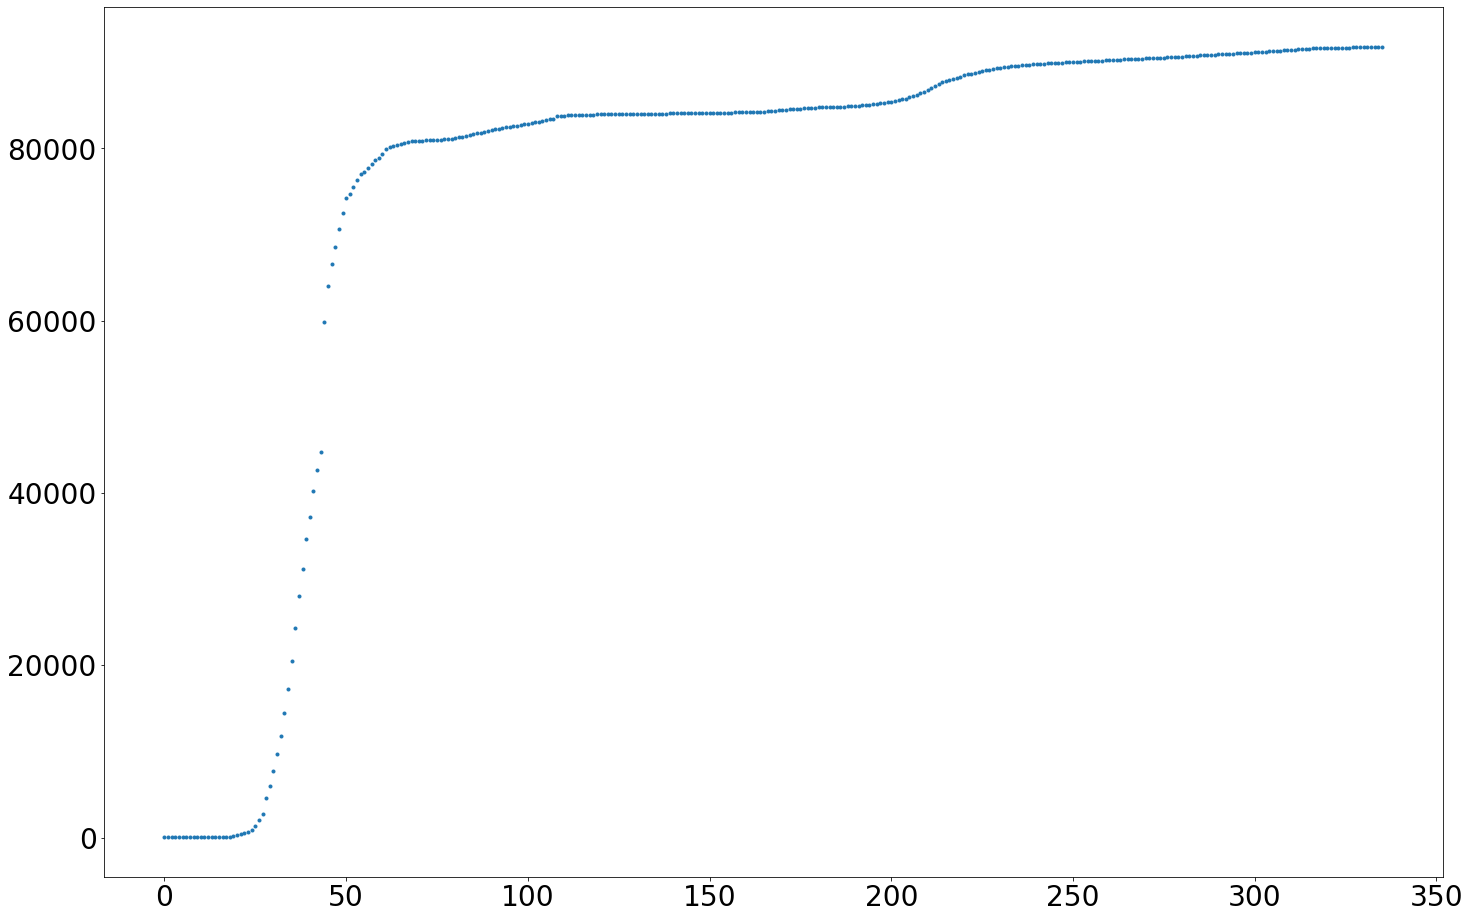

In [98]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 16, forward=True)

plt.plot(x, conf, ".", label="Reported cases")
conf_pred = logistic_function(x, a_, b_, c_, d_)
plt.plot(x, conf_pred, label="Fitted logistic function")
plt.legend()
plt.show()

In [99]:
r2_score(conf, conf_pred)

ValueError: Found input variables with inconsistent numbers of samples: [336, 120]

In [100]:
confirmed_now = confirmed[-1]
confirmed_then = confirmed[-2]
days = 0
now = x[-1]
while confirmed_now - confirmed_then > 10:
    days += 1
    confirmed_then = confirmed_now
    confirmed_now = logistic_function(
        now + days,
        a_,
        b_,
        c_,
        d_,
    )
print(f"In {days} days the number of infected people will plateau at {int(confirmed_now)}")

NameError: name 'confirmed' is not defined

In [101]:
x_ = np.linspace(0, now + days)
plt.plot(
    x_,
    logistic_function(x_, a_, b_, c_, d_)
)
plt.show()

NameError: name 'a_' is not defined

# SIR Fit

In [102]:
"""
SI_IR disease model
Write in the equation here.


States:

Susceptibles: S

Asymptomatic period. Assume case severity is predetermined and each severity may have a unique incubation period.
The asymptomatic population is assumed infectious and unconfirmed.
Asymptomatic states; A_M, A_S, A_C

Symptomatic states; 
Mild_Unconfirmed, Mild_Confirmed, Severe, & Critical. Severe & Critcal are assumed confirmed.

Symptomatics States; M_U, M_C, S_C, C_C

Removed states; Recovered & Died. R, D

States; S, A_M, A_S, A_C, M_U, M_C, S_C, C_C, R, D


Parameters:

T, Testing rate, controls the ratio of Mild Confirmed and Unconfirmed cases.
B, Transmissivity, Beta, controls the chance of infection given contact with an Infectious

G_M, Probability of a case being Mild
G_S, Probability of a case being Severe
G_C, Probability of a case being Critical

K_M, Rate at which a Mild case produces symptoms
K_S, Rate at which a Severe case produces symptoms
K_C, Rate at which a Critical case produces symptoms

R_M, Rate at which a mild case recovers
R_S, Rate at which a Severe case recovers
R_C, Rate at which a Critical case recovers

D_S, Death Rate Severe, Delta Severe, rate at which a Severe case dies
D_C, Death Rate Critical, Delta Critical,rate at which a Critical case dies

Parameters; T, B, G_M ,G_S, G_C, K_M, K_S, K_C, R_M, R_S, R_C, D_S, D_C

"""

import numpy as np
from ODESolver import ForwardEuler
from matplotlib import pyplot as plt

class SI_IR:
    def __init__(self, T, B, G_M, G_S, G_C, K_M, K_S, K_C, R_M, R_S, R_C, D_S, D_C,        # Rates & Probabilities
                 S0, A_M_0, A_S_0, A_C_0, M_U_0, M_C_0, S_C_0, C_C_0, R_0, D_0):          # States
        """
        T, B, G_M ,G_S, G_C, K_M, K_S, K_C, R_M, R_S, R_C, D_S, D_C: parameters in the ODE system
        S0, A_M_0, A_S_0, A_C_0, M_U_0, M_C_0, S_C_0, C_C_0, R_0, D_0: initial values
        """

        if isinstance(T, (float, int)):
            self.T = lambda t: T 
        elif callable(T):
            self.T = T
            
        if isinstance(B, (float, int)):
            self.B = lambda t: B 
        elif callable(B):
            self.B = B

            
            
## Severity Frxns ##### Severity Frxns ##### Severity Frxns ##### Severity Frxns ##### Severity Frxns ###
        
        if isinstance(G_M, (float, int)):
            # Is number?
            self.G_M = lambda t: G_M 
        elif callable(G_M):
            self.G_M = G_M
            
        if isinstance(G_S, (float, int)):
            # Is number?
            self.G_S = lambda t: G_S 
        elif callable(G_S):
            self.G_S = G_S
            
        if isinstance(G_C, (float, int)):
            # Is number?
            self.G_C = lambda t: G_C 
        elif callable(G_C):
            self.G_C = G_C 
            

            
## Kontraktion Rates ##### Kontraktion Rates ##### Kontraktion Rates ##### Kontraktion Rates ##### Kontraktion Rates ###
        
        if isinstance(K_M, (float, int)):
            # Is number?
            self.K_M = lambda t: K_M 
        elif callable(K_M):
            self.K_M = K_M
            
        if isinstance(K_S, (float, int)):
            # Is number?
            self.K_S = lambda t: K_S 
        elif callable(K_S):
            self.K_S = K_S
            
        if isinstance(K_C, (float, int)):
            # Is number?
            self.K_C = lambda t: K_C 
        elif callable(K_C):
            self.K_C = K_C            
            
            

## Recovery Rates ##### Recovery Rates ##### Recovery Rates ##### Recovery Rates ##### Recovery Rates ###
        
        if isinstance(R_M, (float, int)):
            # Is number?
            self.R_M = lambda t: R_M 
        elif callable(R_M):
            self.R_M = R_M
            
        if isinstance(R_S, (float, int)):
            # Is number?
            self.R_S = lambda t: R_S 
        elif callable(R_S):
            self.R_S = R_S
            
        if isinstance(R_C, (float, int)):
            # Is number?
            self.R_C = lambda t: R_C 
        elif callable(R_C):
            self.R_C = R_C


## Death Rates ##### Death Rates ##### Death Rates ##### Death Rates ##### Death Rates ##### Death Rates ###     

        if isinstance(D_S, (float, int)):
            # Is number?
            self.D_S = lambda t: D_S 
        elif callable(D_S):
            self.D_S = D_S
            
        if isinstance(D_C, (float, int)):
            # Is number?
            self.D_C = lambda t: D_C 
        elif callable(D_C):
            self.D_C = D_C
            
            
            
            

        self.initial_conditions = [S0, A_M_0, A_S_0, A_C_0, M_U_0, M_C_0, S_C_0, C_C_0, R_0, D_0]

    def __call__(self, u, t):

        S, A_M, A_S, A_C, M_U, M_C, S_C, C_C, R, D = u 

        return np.asarray([
            
            # Susceptibles. Assume Severe & Critical cases are isolated.
            -self.B(t)*S*(A_M + A_S + A_C + M_U + M_C), 
            
            # Asymptomatic Mild
            self.B(t)*S*(A_M + A_S + A_C + M_U + M_C)*self.G_M(t) - self.K_M(t)*A_M, 
            
            # Asymptomatic Severe
            self.B(t)*S*(A_M + A_S + A_C + M_U + M_C)*self.G_S(t) - self.K_S(t)*A_S, 
            
            # Asymptomatic Critical
            self.B(t)*S*(A_M + A_S + A_C + M_U + M_C)*self.G_C(t) - self.K_C(t)*A_C, 
            
            # Mild Unconfirmed
            self.K_M(t)*A_M - self.R_M(t)*M_U - self.T(t)*M_U, 
            
            # Mild Confirmed
            self.T(t)*M_U - self.R_M(t)*M_C,
            
            # Severe Confirmed
            self.K_S(t)*A_S - (self.R_S(t) + self.D_S(t))*S_C,
            
            # Critical Confirmed
            self.K_C(t)*A_C - (self.R_C(t) + self.D_C(t))*C_C,
            
            # Recovered
            self.R_M(t)*(M_U + M_C) + self.R_S(t)*S_C + self.R_C(t)*C_C,
            
            # Died
            self.D_S(t)*S_C + self.D_C(t)*C_C
            
        ])

In [103]:
days = 23   # Length of simulation
pop = 5e6
latent_period = 14  # Days. How long someone is asymptomatic.
R_nought = 1.8  # show sources/data
T = 0.003  # Estimate using test count, population, count pos/negatives. ROI test count 17thMarch == 1784 tests 223 cases

days_to_recov_mild = 14       # Average time of 14 days for Mild case until Recovery
days_to_recov_severe = 28     # Average time of 4 weeks (28 Days) until Recovery or Death. 
days_to_death_severe = 28
days_to_recov_critical = 28   # Average time of 4 weeks (28 Days) until Recovery or Death.
days_to_death_critcial = 28


### Initial States ###### Initial States ###### Initial States ###### Initial States ###### Initial States ###

#M_C_0 = 5/pop

A_M_0 = (15*5)/pop #M_C_0/T
S0 = 1 - A_M_0

A_S_0 = 0
A_C_0 = 0
M_U_0 = 0
M_C_0 = 1/pop
S_C_0 = 0
C_C_0 = 0
R_0 = 0
D_0 = 0


### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##


K_M = 1/latent_period   # Assuming latent period is the same for each severity. Probably not True.
K_S = 1/latent_period
K_C = 1/latent_period

# R_nought = Beta*Infectious_Period
# Infectious_Period = Latent_Period + Days_To_Recov_Mild
# Severe & Critical are assumed isolated
# B(Beta) = R_nought/(Latent_Period + Days_To_Recov_Mild)
B = R_nought/(latent_period + days_to_recov_mild)

G_M = 0.81  # Fraction of cases in each severity.
G_S = 0.14
G_C = 0.05


R_M = 1/days_to_recov_mild

## CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ###
# As this model is currently configured the ratio of the rates gives the probabilities of Recovery and Death. 
# Recovery_Probability = R_S/(R_S + D_S)  
# This might not be true. 50% might survive and take 20 days in hospital. 50% die and take 10 days in hospital.
# Recovery_Probability = (1/20)/((1/20) + (1/10) = 33%. 


R_S = 1/days_to_recov_severe
R_C = 1/days_to_death_severe

D_S = 1/days_to_recov_critical
D_C = 1/days_to_death_critcial

#B = lambda t: R_nought/(latent_period + days_to_recov_mild) if (t < 100 or t > 150) else 0.01
# B = lambda t: 0.14 if (t < 15 or t > 40) else 0.0005
B = lambda t: 0.25 #if (t < 15 or t > 40) else 0.0005

In [104]:
def func_sir(x, B):
    
    
    
    days = 23   # Length of simulation
    pop = 5e6
    latent_period = 14  # Days. How long someone is asymptomatic.
    R_nought = 1.8  # show sources/data
    T = 0.003  # Estimate using test count, population, count pos/negatives. ROI test count 17thMarch == 1784 tests 223 cases

    days_to_recov_mild = 14       # Average time of 14 days for Mild case until Recovery
    days_to_recov_severe = 28     # Average time of 4 weeks (28 Days) until Recovery or Death. 
    days_to_death_severe = 28
    days_to_recov_critical = 28   # Average time of 4 weeks (28 Days) until Recovery or Death.
    days_to_death_critcial = 28


    ### Initial States ###### Initial States ###### Initial States ###### Initial States ###### Initial States ###

    #M_C_0 = 5/pop

    A_M_0 = (15*5)/pop #M_C_0/T
    S0 = 1 - A_M_0

    A_S_0 = 0
    A_C_0 = 0
    M_U_0 = 0
    M_C_0 = 1/pop
    S_C_0 = 0
    C_C_0 = 0
    R_0 = 0
    D_0 = 0


    ### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##


    K_M = 1/latent_period   # Assuming latent period is the same for each severity. Probably not True.
    K_S = 1/latent_period
    K_C = 1/latent_period

    # R_nought = Beta*Infectious_Period
    # Infectious_Period = Latent_Period + Days_To_Recov_Mild
    # Severe & Critical are assumed isolated
    # B(Beta) = R_nought/(Latent_Period + Days_To_Recov_Mild)
    B = R_nought/(latent_period + days_to_recov_mild)

    G_M = 0.81  # Fraction of cases in each severity.
    G_S = 0.14
    G_C = 0.05


    R_M = 1/days_to_recov_mild

    ## CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ###
    # As this model is currently configured the ratio of the rates gives the probabilities of Recovery and Death. 
    # Recovery_Probability = R_S/(R_S + D_S)  
    # This might not be true. 50% might survive and take 20 days in hospital. 50% die and take 10 days in hospital.
    # Recovery_Probability = (1/20)/((1/20) + (1/10) = 33%. 


    R_S = 1/days_to_recov_severe
    R_C = 1/days_to_death_severe

    D_S = 1/days_to_recov_critical
    D_C = 1/days_to_death_critcial

    #B = lambda t: R_nought/(latent_period + days_to_recov_mild) if (t < 100 or t > 150) else 0.01
    # B = lambda t: 0.14 if (t < 15 or t > 40) else 0.0005
    #B = lambda t: 0.25 #if (t < 15 or t > 40) else 0.0005
    
    
    sir = SI_IR(T, B, G_M, G_S, G_C, K_M, K_S, K_C, R_M, R_S, R_C, D_S, D_C,\
            S0, A_M_0, A_S_0, A_C_0, M_U_0, M_C_0, S_C_0, C_C_0, R_0, D_0) # Parameters & Initial States
    solver = ForwardEuler(sir)
    solver.set_initial_conditions(sir.initial_conditions)


    time_steps = np.linspace(1, days, days)
    u, t = solver.solve(time_steps)

    MC_list = np.concatenate((np.zeros(1), u[:, 5]), axis=None)
    SC_list = np.concatenate((np.zeros(1), u[:, 6]), axis=None)
    CC_list = np.concatenate((np.zeros(1), u[:, 7]), axis=None)

    MC_unique_count = []
    SC_unique_count = []
    CC_unique_count = []

    for i in range(1, len(MC_list)):
        MC_unique_count.append(MC_list[i] - (MC_list[i-1]*(1 - R_M)))

    for i in range(1, len(SC_list)):
        SC_unique_count.append(SC_list[i] - (SC_list[i-1]*(1 - R_S - D_S)))

    for i in range(1, len(CC_list)):
        CC_unique_count.append(CC_list[i] - (CC_list[i-1]*(1 - R_C - D_C)))


    conf_unique_count = np.add(np.add(MC_unique_count,SC_unique_count),CC_unique_count)
    
    return conf_unique_count

In [105]:
country1 = 'Ireland'
pop = 1000000 * 60

conf = np.cumsum(eu[(eu.COUNTRY == country1) & (eu.CASES > 0)].sort_values(by = 'DATE').CASES).values
x = np.arange(len(conf))

In [106]:
popt, pcov = curve_fit(func_sir, x, conf)

100%|##########| 22/22 [00:00<00:00, 22059.45it/s]


ValueError: operands could not be broadcast together with shapes (23,) (272,) 

In [107]:
popt

array([ 636.36166325,    0.64776321, -170.77459347])

In [108]:
x_fut = np.arange(days)
x_fut = add_constant(x_fut)

In [109]:
x_fut

array([[ 1.,  0.],
       [ 1.,  1.],
       [ 1.,  2.],
       [ 1.,  3.],
       [ 1.,  4.],
       [ 1.,  5.],
       [ 1.,  6.],
       [ 1.,  7.],
       [ 1.,  8.],
       [ 1.,  9.],
       [ 1., 10.],
       [ 1., 11.],
       [ 1., 12.],
       [ 1., 13.],
       [ 1., 14.],
       [ 1., 15.],
       [ 1., 16.],
       [ 1., 17.],
       [ 1., 18.],
       [ 1., 19.],
       [ 1., 20.],
       [ 1., 21.],
       [ 1., 22.]])

In [110]:
conf_pred = func_sir(x_fut, popt[0], popt[1])

TypeError: func_sir() takes 2 positional arguments but 3 were given

In [111]:
conf_pred

array([[-7604.44882164, -8348.68190766],
       [-7604.44882164, -7604.44882164],
       [-7604.44882164, -6871.74652106],
       [-7604.44882164, -6150.48072546],
       [-7604.44882164, -5440.55715432],
       [-7604.44882164, -4741.88152715],
       [-7604.44882164, -4054.35956346],
       [-7604.44882164, -3377.89698276],
       [-7604.44882164, -2712.39950455],
       [-7604.44882164, -2057.77284834],
       [-7604.44882164, -1413.92273363],
       [-7604.44882164,  -780.75487994],
       [-7604.44882164,  -158.17500675],
       [-7604.44882164,   453.91116641],
       [-7604.44882164,  1055.59792004],
       [-7604.44882164,  1646.97953463],
       [-7604.44882164,  2228.15029069],
       [-7604.44882164,  2799.2044687 ],
       [-7604.44882164,  3360.23634916],
       [-7604.44882164,  3911.34021256],
       [-7604.44882164,  4452.6103394 ],
       [-7604.44882164,  4984.14101017],
       [-7604.44882164,  5506.02650536],
       [-7604.44882164,  6018.36110547],
       [-7604.44

ValueError: x and y must have same first dimension, but have shapes (23,) and (120, 2)

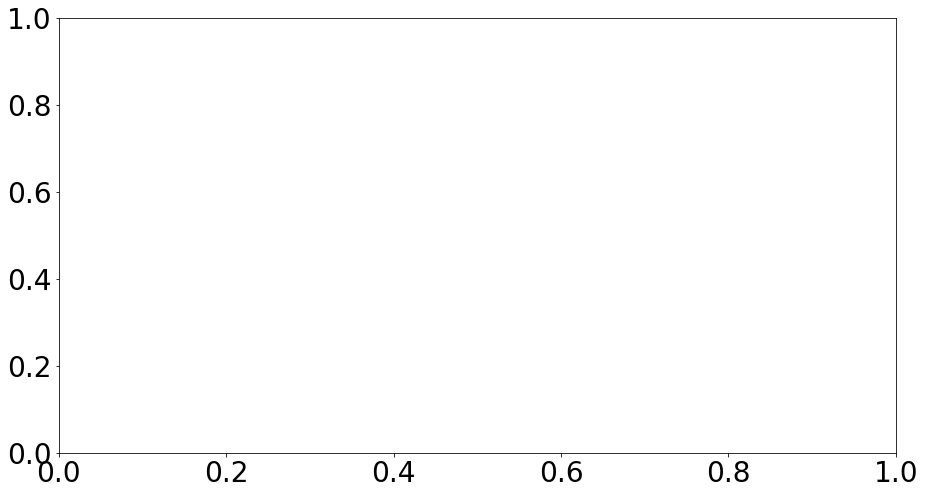

In [112]:

fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)


plt.plot(x_fut[:,1], conf_pred, label="Gompertz Growth Model")

In [113]:
def func_gomp(x, N0, a, c):
    return N0*np.exp((a/c)*(1-np.exp(-c*x)))

country1 = 'Ireland'
pop = 1000000 * 60

#days = 70

conf = np.cumsum(eu[(eu.COUNTRY == country1) & (eu.CASES > 0)].sort_values(by = 'DATE').CASES).values

conf = conf#/pop

#conf_trunc = conf[:days]
x = np.arange(len(conf))
#x = add_constant(x)
#x_trunc = x[:days]

popt, pcov = curve_fit(func_gomp, x, conf)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [ ]:
conf_pred = func_gomp(x_fut, popt[0], popt[1], popt[2])

fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)


plt.plot(x_fut[:,1], conf_pred[:,1], label="Gompertz Growth Model")

In [ ]:
country1 = 'Ireland'

#days = 70

conf = np.cumsum(eu[(eu.COUNTRY == country1) & (eu.CASES > 0)].sort_values(by = 'DATE').CASES).values
#conf_trunc = conf[:days]
x = np.arange(len(conf))
x = add_constant(x)
#x_trunc = x[:days]

#conf += 1

# create model
pmodel = Model(func_poly)
# create parameters -- these are named from the function arguments --
# giving initial values
params = pmodel.make_params(a=0, b=0, c=0, d=0)

result = pmodel.fit(conf, params, x=x[:,1])

result.params

In [62]:
import os
import glob

In [63]:
os.chdir("C:\Users\ivan\Documents\Python Scripts")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-63-8c364b60f5d8>, line 1)

In [64]:
# extension = 'csv'
# all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

# all_filenames = all_filenames[:48]

# all_filenames

# # #combine all files in the list
# # combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
# # #export to csv
# # combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

# df = pd.read_csv('03-09-2020.csv')

# df.head()

In [265]:
df = pd.read_excel('COVID_fixed_dates.xlsx')

df = df.drop(['Latitude', 'Longitude'], axis=1)
df = df.drop(['Last Update'], axis=1)

df.rename(columns={'Confirmed': 'CONFIRMED'}, inplace=True)
df.rename(columns={'Country/Region': 'COUNTRY'}, inplace=True)
df.rename(columns={'Deaths': 'DEATHS'}, inplace=True)
df.rename(columns={'Province/State': 'STATE'}, inplace=True)
df.rename(columns={'Recovered': 'RECOVERED'}, inplace=True)


df = pd.merge(df, df.groupby('COUNTRY').min().DATE, right_on='COUNTRY', left_on='COUNTRY', how='inner')
df.rename(columns={'DATE_y': 'FIRST_INFEXN_DATE'}, inplace=True)
df.rename(columns={'DATE_x': 'DATE'}, inplace=True)

df.head()

,CONFIRMED,COUNTRY,DEATHS,DATE,STATE,RECOVERED,FIRST_INFEXN_DATE
0,422.0,Mainland China,2.0,2020-02-01,Henan,3.0,2020-01-22
1,286.0,Mainland China,0.0,2020-02-01,Jiangxi,9.0,2020-01-22
2,207.0,Mainland China,1.0,2020-02-01,Sichuan,3.0,2020-01-22
3,100.0,Mainland China,0.0,2020-02-01,Guangxi,2.0,2020-01-22
4,96.0,Mainland China,1.0,2020-02-01,Hebei,0.0,2020-01-22


In [266]:
df[df.COUNTRY == 'Ireland']

,CONFIRMED,COUNTRY,DEATHS,DATE,STATE,RECOVERED,FIRST_INFEXN_DATE
4256,1.0,Ireland,0.0,2020-02-29,NaN,0.0,2020-02-29
4257,1.0,Ireland,0.0,2020-03-01,NaN,0.0,2020-02-29
4258,1.0,Ireland,0.0,2020-03-01,NaN,0.0,2020-02-29
4259,2.0,Ireland,0.0,2020-03-03,NaN,0.0,2020-02-29
4260,6.0,Ireland,0.0,2020-03-04,NaN,0.0,2020-02-29
4261,6.0,Ireland,0.0,2020-03-04,NaN,0.0,2020-02-29
4262,18.0,Ireland,0.0,2020-03-06,NaN,0.0,2020-02-29
4263,18.0,Ireland,0.0,2020-03-06,NaN,0.0,2020-02-29
4264,19.0,Ireland,0.0,2020-03-08,NaN,0.0,2020-02-29
4265,21.0,Ireland,0.0,2020-03-09,NaN,0.0,2020-02-29


In [609]:
country_list = eu.groupby('COUNTRY').min().index.values

first_infxn_list = []
for country in eu.groupby('COUNTRY').min().index.values:
    first_infxn_list.append(eu[(eu.COUNTRY == country) & (eu.CASES > 3)].DATE.min())
    
dataset = pd.DataFrame({'CUM_CASES': np.cumsum(eu[eu.COUNTRY == country1].sort_values(by='DATE').CASES),
                        'DATE': (eu[eu.COUNTRY == country1].sort_values(by='DATE').DATE),
                        'COUNTRY': (eu[eu.COUNTRY == country1].sort_values(by='DATE').COUNTRY)})


eu = pd.merge(eu, dataset, right_on='COUNTRY', left_on='COUNTRY', how='inner')

eu.rename(columns={'DATE_y': 'CUM_DATE'}, inplace=True)
eu.rename(columns={'DATE_x': 'DATE'}, inplace=True)

In [613]:
eu.head()

,DATE,COUNTRY,CASES,DEATHS,FIRST_INFEXN_DATE,DAYS_SINCE,CUM_CASES,CUM_DATE
0,2020-03-10,China,20,17,2019-12-31,70.0,27,2019-12-31
1,2020-03-10,China,20,17,2019-12-31,70.0,27,2020-01-01
2,2020-03-10,China,20,17,2019-12-31,70.0,27,2020-01-02
3,2020-03-10,China,20,17,2019-12-31,70.0,44,2020-01-03
4,2020-03-10,China,20,17,2019-12-31,70.0,44,2020-01-04


In [430]:
# ### getting the 'last' infection date per country ######


# country_list = eu.groupby('COUNTRY').max().index.values

# last_infxn_list = []
# for country in eu.groupby('COUNTRY').max().index.values:
#     last_infxn_list.append(eu[(eu.COUNTRY == country) & (eu.CASES > 0)].DATE.max())
    
# dataset = pd.DataFrame({'LAST_INFEXN_DATE': last_infxn_list, 'COUNTRY': country_list})

# eu = pd.merge(eu, dataset, right_on='COUNTRY', left_on='COUNTRY', how='inner')
# eu.rename(columns={'DATE_y': 'LAST_INFEXN_DATE'}, inplace=True)
# eu.rename(columns={'DATE_x': 'DATE'}, inplace=True)


# #eu['LAST_INFEXN_DATE'].mask(eu['LAST_INFEXN_DATE'] > '2020-03-08',  pd.NaT, inplace=True)

In [477]:
from scipy.stats import weibull_min

In [522]:
c, loc, scale = weibull_min.fit(set3)

In [481]:
def weib(x,n,a):
    return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)

In [523]:
x3

array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
        -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
         6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50], dtype=int64)

In [524]:
set3

3961       0
3960       0
3959       0
3958       0
3957       0
3956       0
3955       0
3954       0
3953       0
3952       0
3951       0
3950       0
3949       0
3948       0
3947       0
3946       0
3945       0
3944       0
3943       0
3942       0
3941       1
3940       1
3939       1
3938       1
3937       2
3936       2
3935       3
3934       4
3933       4
3932       4
3931       4
3930       7
3929      12
3928      15
3927      15
3926      16
3925      18
3924      23
3923      24
3922      24
3921      25
3920      27
3919      28
3918      28
3917      28
3916      28
3915      28
3914      29
3913      30
3912      31
3911      46
3910      80
3909     155
3908     345
3907     601
3906     762
3905     892
3904    1146
3903    1595
3902    2022
3901    2931
3900    3526
3899    4212
3898    4812
3897    5328
3896    5766
3895    6284
3894    6767
3893    7134
3892    7382
3891    7513
Name: CASES, dtype: int64

In [525]:
p

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.35938568e-13, 1.85389653e-01, 2.48972165e-01, 2.93943627e-01,
       3.29538489e-01, 3.59272451e-01, 3.84924047e-01, 4.07537254e-01,
       4.27784930e-01, 4.46129745e-01, 4.62905373e-01, 4.78361429e-01,
       4.92690158e-01, 5.06043160e-01, 5.18542356e-01, 5.30287428e-01,
       5.41361046e-01, 5.51832609e-01, 5.61761007e-01, 5.71196681e-01,
       5.80183204e-01, 5.88758495e-01, 5.96955779e-01, 6.04804343e-01,
       6.12330148e-01, 6.19556322e-01, 6.26503568e-01, 6.33190494e-01,
       6.39633891e-01, 6.45848970e-01, 6.51849551e-01, 6.57648235e-01,
       6.63256545e-01, 6.68685043e-01, 6.73943440e-01, 6.79040684e-01,
      

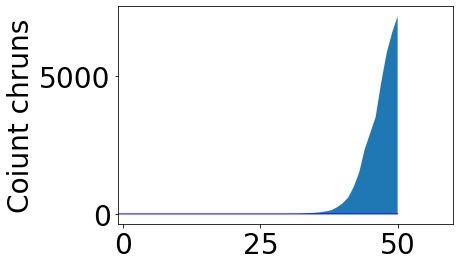

In [526]:
#speeds = np.linspace(0, 80, 1000)    
p = weibull_min.cdf(x3, c, loc, scale)

plt.plot(x3, p, 'b', linewidth=1)
plt.fill_between(x3, set1)
plt.ylabel('Coiunt chruns')
plt.xlim(-1,60)
plt.show()

In [482]:
plt.plot(x3, weib(x3, loc, scale))
plt.hist(data, data.max(), normed=True)
plt.show()

NameError: name 'loc' is not defined

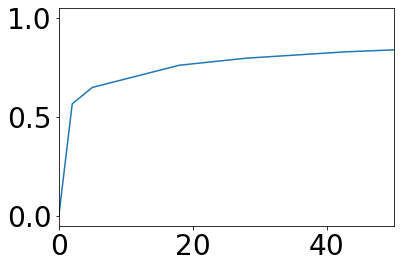

In [502]:
from scipy import stats
import matplotlib.pyplot as plt

plt.plot(set1, stats.exponweib.cdf(set1, *stats.exponweib.fit(set1, 1, 1, scale=2, loc=0)))

plt.xlim(0,50)
plt.show()


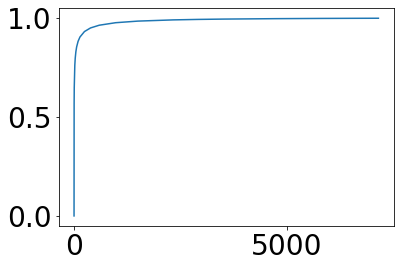

In [503]:
plt.plot(set1, stats.exponweib.cdf(set1, *stats.exponweib.fit(set1, 1, 1, scale=2, loc=0)))

In [43]:
#df.nunique(axis=0).SUBSCRIBER_NUMBER

# df_rev = df[df.ACTION_TYPE == 'REVENUE']
# df_top = df[df.ACTION_TYPE == 'TOPUP']
# df_sub = df[df.ACTION_TYPE == 'SUBSCRIP']

# def dadate(act_date):
#     return datetime.strptime(act_date, '%Y-%m-%d %H:%M:%S').date()

# df['ACTION_DATE'] = df.apply(lambda row: dadate(row['ACTION_DATE']), axis=1)

#df_sub.groupby('ACTION_DESC').count().sort_values(by = 'SUBSCRIBER_NUMBER', ascending = False)

# df = df[df.ACTION_TYPE == 'TOPUP']

# cohorts group by first transxn date

In [8]:
lifetimes = (df.groupby('SUBSCRIBER_NUMBER').max().DATE - df.groupby('SUBSCRIBER_NUMBER').min().DATE)
lifetimes = lifetimes.astype('timedelta64[D]')

df = pd.merge(df, df.groupby('SUBSCRIBER_NUMBER').min().DATE, right_on='SUBSCRIBER_NUMBER', left_on='SUBSCRIBER_NUMBER', how='inner')
df.rename(columns={'DATE_y': 'MIN_DATE'}, inplace=True)
df.rename(columns={'DATE_x': 'DATE'}, inplace=True)

df = pd.merge(df, df.groupby('SUBSCRIBER_NUMBER').max().DATE, right_on='SUBSCRIBER_NUMBER', left_on='SUBSCRIBER_NUMBER', how='inner')
df.rename(columns={'DATE_y': 'MAX_DATE'}, inplace=True)
df.rename(columns={'DATE_x': 'DATE'}, inplace=True)

df = pd.merge(df, lifetimes, right_on='SUBSCRIBER_NUMBER', left_on='SUBSCRIBER_NUMBER', how='inner')
df.rename(columns={'DATE_y': 'LIFETIME'}, inplace=True)
df.rename(columns={'DATE_x': 'DATE'}, inplace=True)

df.head()

,SUBSCRIBER_NUMBER,ACTION_DATE,VOLUME,ACTION_TYPE,ACTION_DESC,BALANCE_BEFORE,DATE,MIN_DATE,MAX_DATE,LIFETIME
0,13453257472,2020-02-07 20:15:55,5.0,TOPUP,Retail - DirectTopupSystem - On Island,-2.66,2020-02-07 20:15:55,2017-02-16 18:35:17,2020-02-07 20:15:55,1086.0
1,13453257472,2020-02-07 16:43:04,5.0,TOPUP,Retail - INSwitch - On Island,-2.70,2020-02-07 16:43:04,2017-02-16 18:35:17,2020-02-07 20:15:55,1086.0
2,13453257472,2020-01-27 20:07:40,6.0,TOPUP,Retail - DirectTopupSystem - On Island,-2.69,2020-01-27 20:07:40,2017-02-16 18:35:17,2020-02-07 20:15:55,1086.0
3,13453257472,2020-01-28 16:20:22,5.0,TOPUP,Retail - DirectTopupSystem - On Island,-0.78,2020-01-28 16:20:22,2017-02-16 18:35:17,2020-02-07 20:15:55,1086.0
4,13453257472,2020-01-24 22:11:31,5.0,TOPUP,Retail - DirectTopupSystem - On Island,-2.21,2020-01-24 22:11:31,2017-02-16 18:35:17,2020-02-07 20:15:55,1086.0


In [9]:
conditions = [
(df.MIN_DATE > '2017-02') & (df.MIN_DATE <= '2017-04'),
(df.MIN_DATE > '2017-04') & (df.MIN_DATE <= '2017-06'),
(df.MIN_DATE > '2017-06') & (df.MIN_DATE <= '2017-08'),
(df.MIN_DATE > '2017-08') & (df.MIN_DATE <= '2017-10'),
(df.MIN_DATE > '2017-10') & (df.MIN_DATE <= '2017-12'),
(df.MIN_DATE > '2017-12') & (df.MIN_DATE <= '2018-02'),
(df.MIN_DATE > '2018-02') & (df.MIN_DATE <= '2018-04'),
(df.MIN_DATE > '2018-04') & (df.MIN_DATE <= '2018-06'),
(df.MIN_DATE > '2018-06') & (df.MIN_DATE <= '2018-08'),
(df.MIN_DATE > '2018-08') & (df.MIN_DATE <= '2018-10'),
(df.MIN_DATE > '2018-10') & (df.MIN_DATE <= '2018-12'),
(df.MIN_DATE > '2018-12') & (df.MIN_DATE <= '2019-02'),
(df.MIN_DATE > '2019-02') & (df.MIN_DATE <= '2019-04'),
(df.MIN_DATE > '2019-04') & (df.MIN_DATE <= '2019-06'),
(df.MIN_DATE > '2019-06') & (df.MIN_DATE <= '2019-08'),
(df.MIN_DATE > '2019-08') & (df.MIN_DATE <= '2019-10'),
(df.MIN_DATE > '2019-10') & (df.MIN_DATE <= '2019-12'),
(df.MIN_DATE > '2019-12') & (df.MIN_DATE <= '2020-02'),
]

In [10]:
choices = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
df['COHORT'] = np.select(conditions, choices, default='black')

In [11]:
df['MAX_DATE'].mask(df['MAX_DATE'] > '2020',  pd.NaT, inplace=True)

In [39]:
len(df)

2945253

In [20]:
sam_df = df.sample(n=100000)

In [21]:
unit, groups, (G, B, T) = convoys.utils.get_arrays(
    sam_df, groups='COHORT', created='MIN_DATE', converted='MAX_DATE',
    unit='days', group_min_size=100)

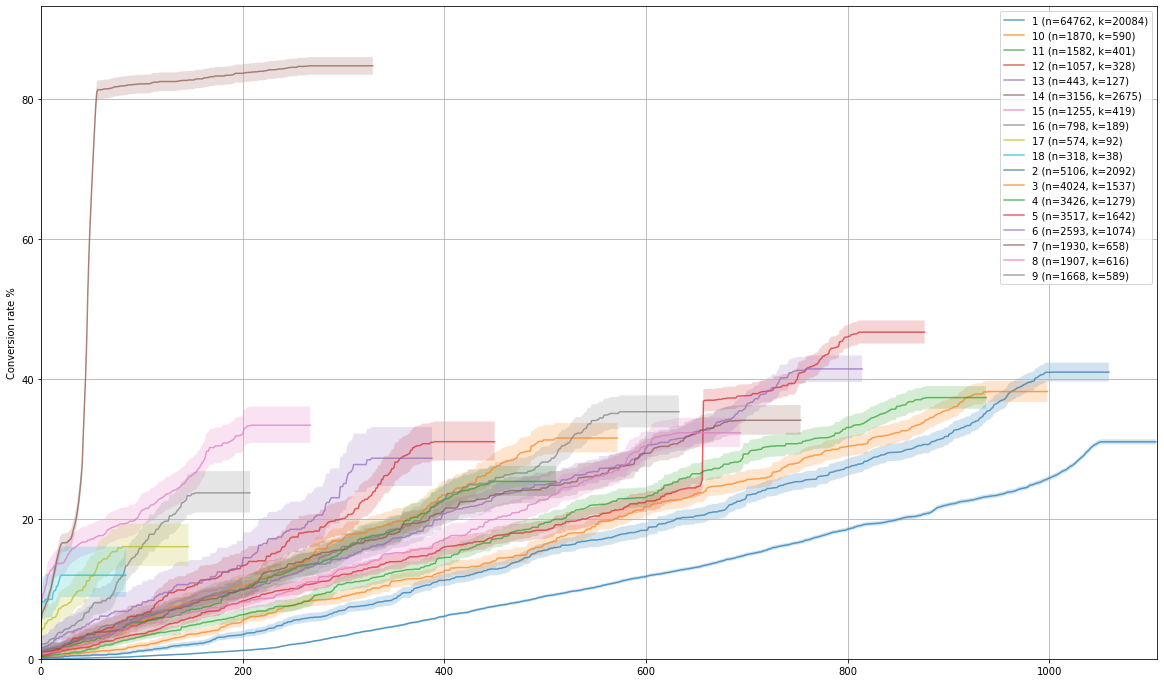

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 12, forward=True)

convoys.plotting.plot_cohorts(G, B, T, model='kaplan-meier', ci=0.95, groups=groups)
plt.legend()
plt.show()

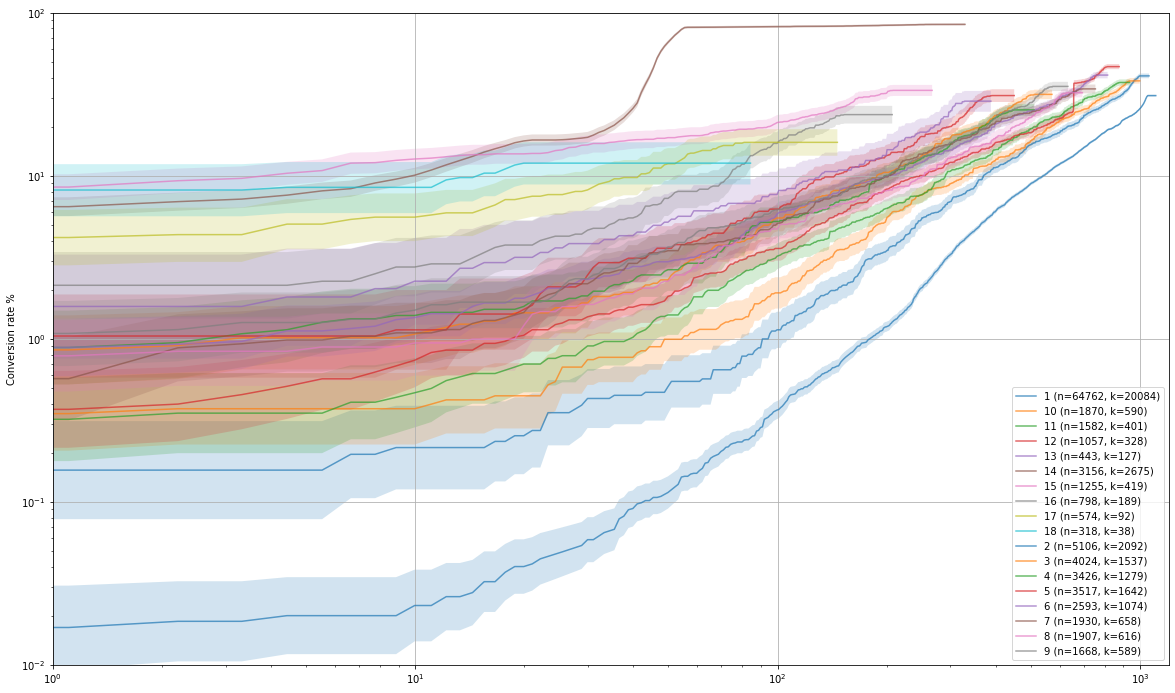

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 12, forward=True)

convoys.plotting.plot_cohorts(G, B, T, model='kaplan-meier', ci=0.95, groups=groups)

plt.xscale('log')
plt.xlim(1,1200)

plt.yscale('log')
plt.ylim(0.01, 100)

plt.legend()
plt.show()

In [ ]:
df_dob = pd.read_pickle('dob_violations.pickle')
len(df_dob)

In [105]:
df_dob.head()

,issue_date,disposition_date,now,boro,category,type
747773,2014-02-27,2014-09-23,2018-01-01,Brooklyn,V*-DOB VIOLATION - Resolved,E-ELEVATOR
1941892,2001-03-08,2002-09-26,2018-01-01,Brooklyn,V*-DOB VIOLATION - DISMISSED,LL1081-LOCAL LAW 10/81 - ELEVATOR
1451830,2007-11-07,2008-07-25,2018-01-01,Brooklyn,V*-DOB VIOLATION - Resolved,E-ELEVATOR
541229,1988-07-25,1989-06-08,2018-01-01,Manhattan,V*-DOB VIOLATION - DISMISSED,C-CONSTRUCTION
830086,1994-06-07,NaT,2018-01-01,Queens,V-DOB VIOLATION - ACTIVE,LL6291-LOCAL LAW 62/91 - BOILERS


In [102]:
unit, groups, (G, B, T) = convoys.utils.get_arrays(
    df_dob, groups='type', created='issue_date', converted='disposition_date',
    unit='years', group_min_size=100)

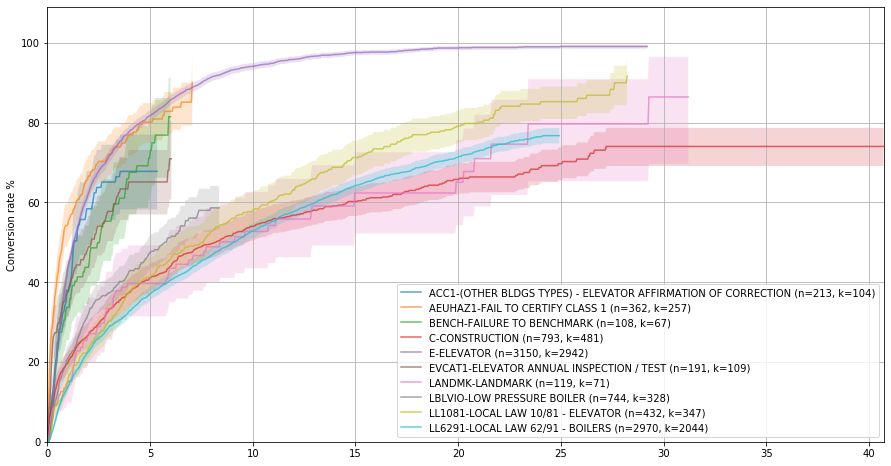

In [104]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

convoys.plotting.plot_cohorts(G, B, T, model='kaplan-meier', ci=0.95, groups=groups)
plt.legend()
plt.show()

In [ ]:
df_dob['bucket'] = df_dob['issue_date'].apply(lambda d: '%d-%d' % (5*(d.year//5), 5*(d.year//5)+4))
unit, groups, (G, B, T) = convoys.utils.get_arrays(
    df_dob, groups='bucket', created='issue_date', converted='disposition_date',
    unit='years', group_min_size=500)

100% |############################################| 90 walkers [ETA:  00:00:00]

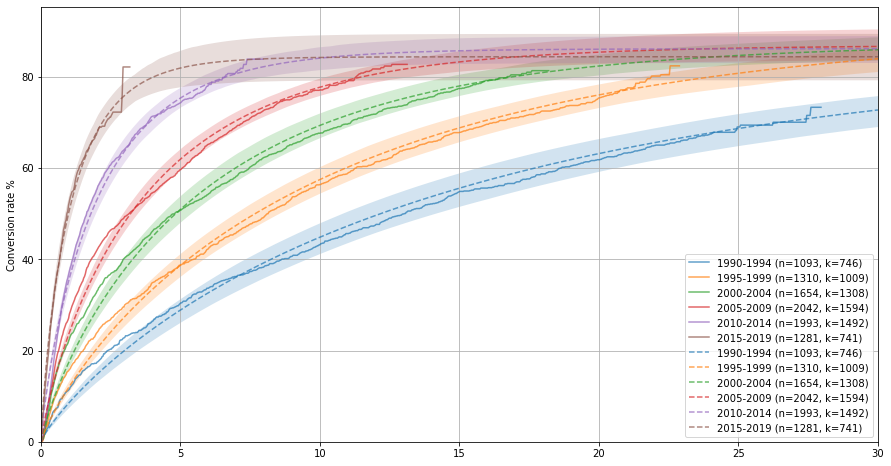

In [107]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

convoys.plotting.plot_cohorts(G, B, T, model='kaplan-meier', groups=groups, t_max=30)
convoys.plotting.plot_cohorts(G, B, T, model='weibull', groups=groups, t_max=30, plot_kwargs={'linestyle': '--'}, ci=0.95)
plt.legend()
plt.show()

In [111]:
df_dob[df_dob.bucket == '2015-2019']

,issue_date,disposition_date,now,boro,category,type,bucket
1552236,2017-01-22,2017-05-01,2018-01-01,Brooklyn,V*-DOB VIOLATION - Resolved,E-ELEVATOR,2015-2019
43039,2016-06-01,NaT,2018-01-01,Brooklyn,V-DOB VIOLATION - ACTIVE,EVCAT5-NON-RESIDENTIAL ELEVATOR PERIODIC INSPE...,2015-2019
913596,2017-01-03,2017-08-29,2018-01-01,Manhattan,V*-DOB VIOLATION - DISMISSED,ACC1-(OTHER BLDGS TYPES) - ELEVATOR AFFIRMATIO...,2015-2019
35321,2016-11-14,NaT,2018-01-01,Manhattan,V-DOB VIOLATION - ACTIVE,ACC1-(OTHER BLDGS TYPES) - ELEVATOR AFFIRMATIO...,2015-2019
1234782,2015-02-13,2015-07-09,2018-01-01,The Bronx,V*-DOB VIOLATION - Resolved,E-ELEVATOR,2015-2019
1437103,2017-01-03,NaT,2018-01-01,Manhattan,V-DOB VIOLATION - ACTIVE,ACC1-(OTHER BLDGS TYPES) - ELEVATOR AFFIRMATIO...,2015-2019
1512154,2017-01-03,2017-06-09,2018-01-01,The Bronx,V*-DOB VIOLATION - DISMISSED,ACH1-(NYCHA) - ELEVATOR AFFIRMATION OF CORRECTION,2015-2019
432118,2015-03-03,NaT,2018-01-01,Manhattan,V-DOB VIOLATION - ACTIVE,LBLVIO-LOW PRESSURE BOILER,2015-2019
1717840,2015-10-01,NaT,2018-01-01,Brooklyn,V-DOB VIOLATION - ACTIVE,LBLVIO-LOW PRESSURE BOILER,2015-2019
1431864,2015-07-11,NaT,2018-01-01,Brooklyn,V-DOB VIOLATION - ACTIVE,UB-UNSAFE BUILDINGS,2015-2019
